# Import Packages

In [1]:
#Download a new library e.g. python -m pip install matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy
import scipy.integrate as integrate
import scipy.stats as stats
from scipy.optimize import curve_fit
import math
import time
from tqdm import trange
import h5py
import matplotlib.colors as colors
import matplotlib.cbook as cbook

Notes:

This code defines the Metropolis-Hastings algorithm in python for sampling the Bayesian posterior PDFs of null point method data

The shape of the PDF will depend on signal to noise ratio (SNR) and the choice of our 6 parameters: c1, c2, T11, T12, T21, and T22

Generally, this code can be used by adjusting SNR and parameters below, then running Metropolis (usually the 4 parameter version) using one of the definitions below:

    "Run 4 Parameter Metropolis" section runs the algorithm across one choice of TI, while the "Iterate through TI values..." section moves through many values of TI and saves the Metropolis data as an hdf5 file

When indexing parameters in the 4 parameter problem, the 0 index refers to d1, 1 to d2, 2 to T21, and 3 to T22

# Define parameters

In [2]:
#Set the signal-to-noise ratio and standard deviation of the gaussian noise, which can be roughly estimated as 1/SNR
SNR = 1000
noise_sd = 1/SNR
#Normalization Constant to get the T_ij and c_j around the same range
#Based on the decay time of pure water
t_norm = 3000
#Set up a 2D grid of points with a TI axis and a TE axis
#TI: Inversion time, TE: Echo time, refer to time values over which MRI images are taken
#_til refers to normalized values
#Here TI and TE are a 2D meshgrid, while TI_set and TE_set are the 1D versions
n_TI = 25
TI_max = 4850
TI_set = np.linspace(TI_max/n_TI, TI_max, n_TI)
TI_til_set = TI_set/t_norm
n_TE = 64
TE_max = 512
TE_set = np.linspace(TE_max/n_TE, TE_max, n_TE)
TE_til_set = TE_set/t_norm
TI, TE = np.meshgrid(TI_set, TE_set, indexing='ij')
TI_til, TE_til = np.meshgrid(TI_til_set, TE_til_set, indexing='ij')
n_elements = n_TI*n_TE
#Define true values of the 6 parameters
c1 = 0.5
c2 = 0.5
T11 = 600
T12 = 1200
T21 = 50
T22 = 150
#Define normalized values for the six parameters, not really needed anymore but here they are
T11_til = T11/t_norm
T12_til = T12/t_norm
T21_til = T21/t_norm
T22_til = T22/t_norm

### 6p Metropolis Parameters

In [3]:
step_c1 = 0.0025
step_c2 = 0.0025
step_T11 = 0.0025
step_T12 = 0.0025
step_T21 = 0.0025
step_T22 = 0.0025

c1_max = 1
c2_max = 1
T11_max = TI_max/t_norm
T12_max = TI_max/t_norm
T21_max = TE_max/t_norm
T22_max = TE_max/t_norm
upper_bound = np.array([c1_max, c2_max, T11_max, T12_max, T21_max, T22_max])
lower_bound = np.zeros(6)

# Define Useful Functions

In [4]:
def S(TI, TE, c1, c2, T11, T12, T21, T22):
    #Defines the 6 parameter model along the TIxTE axis
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1+exp2

def S_raveled(T, c1, c2, T11, T12, T21, T22):
    #Gives a flattened 1D version of the above model, useful for applying curve_fit
    TI = T[0]
    TE = T[1]
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return (exp1+exp2).ravel()

def S_4_param(TE, d1, d2, T21, T22):
    #Gives a 4 parameter, 1D model. Comes in when plugging in a constant value for TI
    #d1 is defined as c1*(1-2*exp(-TI/T11)) which is a constant for constant values of TI
    model = d1*np.exp(-TE/T21)+d2*np.exp(-TE/T22)
    return model

def S_ME(TE, c, T2):
    #A monoexponential model with 2 parameters
    #When the "correct" TI value is chosen, the data generated will be monoexponential
    model = c*np.exp(-TE/T2)
    return model

def Jacobian_2D(TI, TE, c1, c2, T11, T12, T21, T22):
    #Returns the Jacobian of our 6 parameter, 2D problem
    dc1 = (1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dc2 = (1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    dT11 = (-2*c1*TI/T11**2)*np.exp(-(TI/T11 + TE/T21))
    dT12 = (-2*c2*TI/T12**2)*np.exp(-(TI/T12 + TE/T22))
    dT21 = (c1*TE/T21**2)*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dT22 = (c2*TE/T22**2)*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    
    jacobian = np.stack((dc1, dc2, dT11, dT12, dT21, dT22), axis = -1)
    return jacobian

def covariance_2D(TI, TE, c1, c2, T11, T12, T21, T22, sd = noise_sd):
    #Returns the covariance matrix of our 6 parameter, 2D problem
    jacobian = Jacobian_2D(TI, TE, c1, c2, T11, T12, T21, T22)
    jacobian_T = np.transpose(jacobian)
    mat = np.tensordot(jacobian_T, jacobian, axes = ([2, 1], [0, 1]))
    cov = np.linalg.inv(mat)
    return cov
    
def add_noise(sd, data_obj):
    #Adds noise to an arbitrary object
    return data_obj + np.random.normal(0, sd, data_obj.shape)

def noise_2D(sd):
    #Adds noise to the 2D model
    #sd is standard deviation of the noise, generally 1/SNR, but defined above as noise_sd
    return np.random.normal(0, sd, (n_TI,n_TE))

def noise_TE(sd):
    #Adds noise to the 1D model across the TE axis with constant TI
    return np.random.normal(0, sd, n_TE)

def pdf(data, sd):
    #Returns the Bayesian PDF of the 2D, 6 parameter model
    #To get the Bayesian joint posterior as a function of TI, TE, and parameters, input data and standard deviation of noise into pdf()
    #Output will be a function of TI, TE, c1, c2, T11, T12, T21, and T22 from which you can sample using various methods
    def joint_pdf(TI, TE, c1, c2, T11, T12, T21, T22):
        model = S(TI, TE, c1, c2, T11, T12, T21, T22)
        residual = (data - model)**2
        return np.exp(1/(n_TI*n_TE)*-(1/(2*sd**2))*residual.sum())
    return joint_pdf

def pdf_null_point(TI, data, sd):
    #Returns the Bayesian PDF of the 1D model, here with 6 parameters
    #Use similarly as above, this time also including the value for TI
    #Deprecated, as c_i and T1_i are degenerate in this case. Use the 4 parameter definition below
    def joint_pdf_null_point(TE, c1, c2, T11, T12, T21, T22):
        model = S(TI, TE, c1, c2, T11, T12, T21, T22)
        residual = (data-model)**2
        return np.exp(1/(n_TE)*-(1/(2*sd**2))*residual.sum())
    return joint_pdf_null_point

def pdf_np_4_param(data, sd):
    #Returns the Bayesian PDF of the 1D model, here with 4 parameters
    #Given the data (generated for a particular TI) and noise sd, 
    #returns Bayesian posterior joint PDF as a function of TE, d1, d2, T21, and T22
    def joint_pdf(TE, d1, d2, T21, T22):
        model = S_4_param(TE, d1, d2, T21, T22)
        residual = (data-model)**2
        return np.exp(1/(n_TE)*-(1/(2*sd**2))*residual.sum())
    return joint_pdf

def pdf_np_ME(data, sd):
    #Returns the Bayesian PDF of the 1D monoexponential model, with 2 parameters
    #Can be used similarly as above
    def joint_pdf(TE, c, T2):
        model = S_ME(TE, c, T2)
        residual = (data-model)**2
        return np.exp(1/(n_TE)*(-1/(2*sd**2))*residual.sum())
    return joint_pdf
    
def max_joint_pdf(joint, bins=25):
    #Given a multi-dimensional joint PDF with number of dimensions dims, returns the values for each parameter at the peak
    H, edges = np.histogramdd(joint, bins=bins)
    max_bin = np.unravel_index(np.argmax(H), H.shape)
    
    dims = joint.shape[-1]
    max_values = np.zeros(dims)
    for p in range(dims):
        max_values[p] = edges[p][max_bin[p]]
    
    return max_values

def get_marginal_variance(estimates, bins = 100, norm = False):
    #Returns the variance of estimates, a marginal PDF
    #If the parameter of interest is normalized, so either T21 or T22, set norm to be True
    if norm == True:
        estimates = t_norm*estimates

    hist, bin_edges = np.histogram(estimates, bins = bins, density = True)
    hist_norm = hist/hist.sum()
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    
    mean_bin = np.sum(hist_norm*bin_centers)
    variance = hist_norm.dot((bin_centers - mean_bin)**2)
    
    return variance, mean_bin

def smooth(y, box_pts):
    #Given a noisy curve y and box size box_pts, returns a smoothed version of y. 
    #Further processing to remove edge effects is needed
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def estimate_NLLS(model, t, data, p0):
    #Given the model for fitting, the time series as a vector, and the data set to be fit, give estimates for the parameters
    #p0 will need to be adjusted for different models
    est, cov = curve_fit(model, t, data, bounds=(-1, 3000), p0=p0, max_nfev = 4000)
        
    return est

def get_confidence_interval(estimates, ci, axes=[2,3], bins=100, range=[[0,500],[0,500]]):
    #Given a set of Metropolis estimates, return a histogram of the 2D confidence region of ci along the axes given
    hist, x_edges,y_edges = np.histogram2d(estimates[:,axes[0]],estimates[:,axes[1]],bins=bins,density=True,range=range)
    max_val = np.max(hist)
    min_val = np.min(hist[hist>0])
    area = (x_edges[1]-x_edges[0])**2
    
    p_set = np.logspace(np.log10(min_val), np.log10(max_val), 500)
    frac = 1.0
    i=0
    while frac > ci:
        p_star = p_set[i]
        frac_remaining = np.copy(hist)
        frac_remaining[frac_remaining<p_star] = 0
        frac = np.sum(frac_remaining*area)
        i+=1
    n_bins_remaining = frac_remaining[frac_remaining>0].size
    
    return frac_remaining, x_edges, y_edges, p_star, n_bins_remaining

def get_confidence_interval_4D(estimates, cr, bins=100, range_4D = [(-1,1),(-1,1),(0, 250),(0,250)]):
    #Given a set of 4D Metropolis estimates, return a histogram of the 4D confidence region of fraction cr along the axes given
    H, edges = np.histogramdd(estimates, bins=100, density=True, range = range_4D)
    max_val = np.max(H)
    min_val = np.min(H[H>0])
    d1_incr = edges[0][1] - edges[0][0]
    d2_incr = edges[1][1] - edges[1][0]
    T21_incr = edges[2][1] - edges[2][0]
    T22_incr = edges[3][1] - edges[3][0]
    hyper_vol = d1_incr*d2_incr*T21_incr*T22_incr
    p_set = np.logspace(np.log10(min_val), np.log10(max_val), 50)
    frac = 1.0
    i = 0
    while frac > cr:
        p_star = p_set[i]
        frac_remaining = np.copy(H)
        frac_remaining[frac_remaining<p_star] = 0
        frac = np.sum(frac_remaining*hyper_vol)
        i+=1
        
    n_bins_remaining = frac_remaining[frac_remaining>0].size
    total_volume = np.sum(frac_remaining*np.diff(edges[0]).reshape(-1,1)
                          *np.diff(edges[1]).reshape(-1,1)*np.diff(edges[2]).reshape(-1, 1)*np.diff(edges[3]).reshape(-1,1))
    
    return frac_remaining, edges, p_star, n_bins_remaining, total_volume

# Visualize the Model

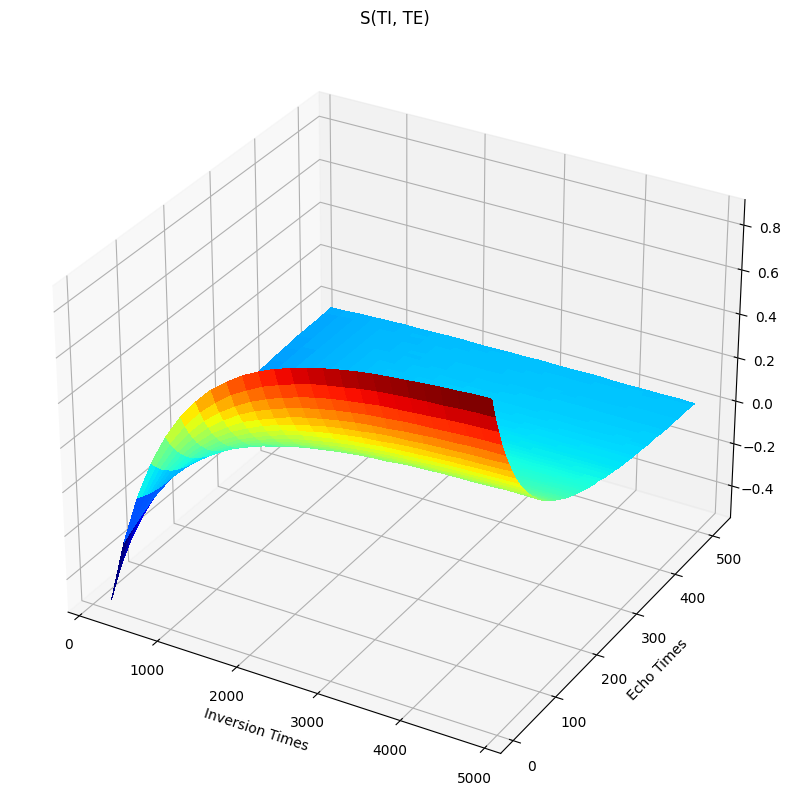

In [5]:
np.random.seed(64)
underlying = S(TI, TE, c1, c2, T11, T12, T21, T22)
data = underlying + noise_2D(noise_sd)

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection='3d')

#surf = ax.plot_surface(TI, TE, underlying, rstride=1, cstride=1, cmap = plt.cm.jet,linewidth=0, antialiased=False)
surf = ax.plot_surface(TI, TE, data, rstride=1, cstride=1, cmap = plt.cm.jet, linewidth=0, antialiased=False)
#ax.plot_surface(TI, TE, data)

ax.set_title('S(TI, TE)')
ax.set_xlabel('Inversion Times')
ax.set_ylabel('Echo Times')
plt.show()

## Visualize model with null point

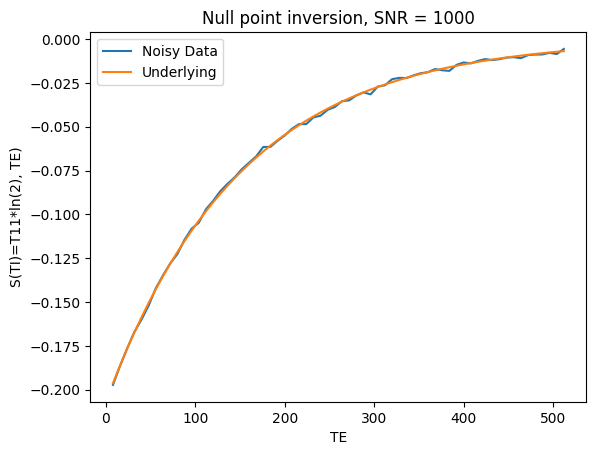

In [6]:
#Set a TI value
TI_np = T11*np.log(2)
#Generate the underlying noiseless signal
underlying = S(TI_np, TE_set, c1, c2, T11, T12, T21, T22)
data = underlying + noise_TE(noise_sd)

plt.plot(TE_set, data, label = 'Noisy Data')
plt.plot(TE_set, underlying, label = 'Underlying')
plt.xlabel('TE')
plt.ylabel('S(TI)=T11*ln(2), TE)')
plt.title('Null point inversion, SNR = %s' % SNR)
plt.legend()
plt.show()

In [7]:
#Look quickly at NLLS estimates of monoexponential model given biexponential data
f_list = []
T2_list = []
for TI_np_i in np.linspace(200, 1000, 81):
    d1 = c1*(1-2*np.exp(-TI_np_i/T11))
    d2 = c2*(1-2*np.exp(-TI_np_i/T12))
    di_sum = d1+d2

    data_4P = S_4_param(TE_set, d1, d2, T21, T22) + noise_TE(noise_sd)
    est = estimate_NLLS(S_ME, TE_set, data_4P, p0=[(d1+d2)/2,(T21+T22)/2])
    f_list.append(est[0])
    T2_list.append(est[1])

C:\Users\griff\AppData\Local\Temp\ipykernel_1496\424828721.py:24: RuntimeWarning: overflow encountered in exp
  model = c*np.exp(-TE/T2)


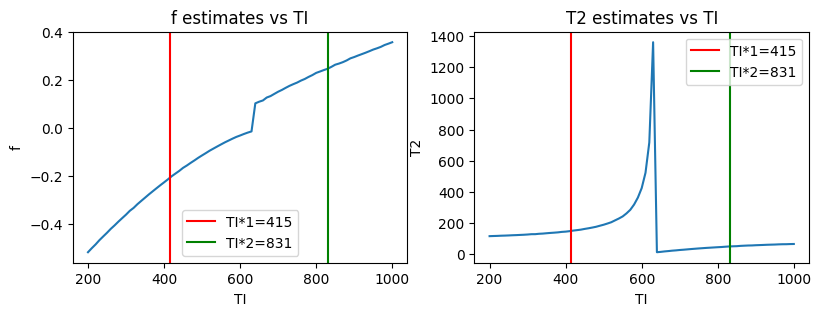

In [8]:
fig, ax = plt.subplots(1,2, figsize=(9.5,3))
ax[0].set_title('f estimates vs TI')
ax[0].set_xlabel('TI')
ax[0].set_ylabel('f')
ax[0].plot(np.linspace(200, 1000, 81), f_list)
ax[0].axvline(x=415, color='r', label='TI*1=415')
ax[0].axvline(x=831, color='g', label='TI*2=831')
ax[0].legend()
ax[1].set_title('T2 estimates vs TI')
ax[1].set_xlabel('TI')
ax[1].set_ylabel('T2')
ax[1].plot(np.linspace(200, 1000, 81), T2_list)
ax[1].axvline(x=415, color='r', label='TI*1=415')
ax[1].axvline(x=831, color='g', label='TI*2=831')
ax[1].legend()
plt.show()

# Define Metropolis functions for 2D problem

In [9]:
def prior(c1, c2, T11, T12, T21, T22):
    #Given a point (c1, c2, T11, T12, T21, T22), returns value of the prior at that point
    #Here, prior is defined as a box within the upper and lower bound, also requires T21 < T22
    isGreater = np.array([c1,c2,T11,T12,T21,T22]) > upper_bound
    isLower = np.array([c1,c2,T11,T12,T21,T22]) < lower_bound
    
    if any(isGreater):
        return 0
    if any(isLower):
        return 0
    if T21>T22 or T11>T12: #Can you have T11 > T12 when T22 > T21?
        return 0
    return 1

def initializeMH(joint_pdf, prior, verbose = False):
    #Randomly initializes metropolis
    #Takes the Bayesian joint posterior as a function of TI, TE, c1, c2, T11, T12, T21, and T22
    #And prior as a function of the six parameters
    c1 = np.random.uniform(0,c1_max)
    c2 = np.random.uniform(0,c2_max)
    T11 = np.random.uniform(0,T11_max)
    T12 = np.random.uniform(0,T12_max)
    T21 = np.random.uniform(0,T21_max)
    T22 = np.random.uniform(0,T22_max)
    iterator = 1
    while joint_pdf(TI,TE,c1,c2,T11,T12,T21,T22)*prior(c1, c2, T11, T12, T21, T22) < 10**(-16):
        c1 = np.random.uniform(0,c1_max)
        c2 = np.random.uniform(0,c2_max)
        T11 = np.random.uniform(0,T11_max)
        T12 = np.random.uniform(0,T12_max)
        T21 = np.random.uniform(0,T21_max)
        T22 = np.random.uniform(0,T22_max)
        iterator += 1
    if verbose == True:
        print('Chose', iterator, 'different initial points')
        print('Initial points:', c1, c2, T11, T12, T21, T22)
    return (c1, c2, T11, T12, T21, T22)

def transition_model(c1, c2, T11, T12, T21, T22):
    #The transition model for Metropolis-Hastings
    #Given a step size for each parameter and a current position, calculates where the next step will be
    dc1 = step_c1*np.random.normal(0,1)
    dc2 = step_c2*np.random.normal(0,1)
    dT11 = step_T11*np.random.normal(0,1)
    dT12 = step_T12*np.random.normal(0,1)
    dT21 = step_T21*np.random.normal(0,1)
    dT22 = step_T22*np.random.normal(0,1)
    
    return(c1+dc1, c2+dc2, T11+dT11, T12+dT12, T21+dT21, T22+dT22)

def acceptance(r_current, r_temp):
    #returns true if new parameters are accepted
    if r_temp > r_current:
        return True
    else:
        accept = np.random.uniform(0,1)
        return (accept < r_temp/r_current)
    
def metropolis(likelihood, prior, transition_model, param_init, n_iterations, data, acceptance):
    #Takes the likelihood function from joint_pdf function, and other metropolis helper functions as defined above
    #param_init are the initial parameters for Metropolis-Hastings
    #n_iterations is how many total steps the algorithm will take
    #Set current values to the initial parameters
    c1_c, c2_c, T11_c, T12_c, T21_c, T22_c = param_init
    estimates = np.zeros((n_iterations,6))
    #rejections = []
    for n in trange(n_iterations):
        #Define the possible next step
        c1_temp, c2_temp, T11_temp, T12_temp, T21_temp, T22_temp = transition_model(c1_c, c2_c, T11_c, T12_c, T21_c, T22_c)
    
        r_current = prior(c1_c, c2_c, T11_c, T12_c, T21_c, T22_c)*likelihood(TI_til, TE_til, c1_c, c2_c, T11_c, T12_c, T21_c, T22_c)
        r_temp = prior(c1_temp, c2_temp, T11_temp, T12_temp, T21_temp, T22_temp)*likelihood(TI_til, TE_til, c1_temp, c2_temp, T11_temp, T12_temp, T21_temp, T22_temp)
        
        #Compare current position and possible next position, determine if we move or not
        if acceptance(r_current, r_temp):
            #If accepted, move to the new point. Otherwise, stay put
            c1_c, c2_c, T11_c, T12_c, T21_c, T22_c = c1_temp, c2_temp, T11_temp, T12_temp, T21_temp, T22_temp
        #else:
            #rejections.append(r_temp)
        estimates[n,:] = [c1_c, c2_c, T11_c, T12_c, T21_c, T22_c]
        
    return estimates

def burnin(metropolis, likelihood, prior, transition_model, param_init, n_iterations, data, acceptance):
    #Start by running a "burn-in" time of n_iterations
    burnin = metropolis(likelihood, prior, transition_model, param_init, n_iterations, data, acceptance)

    return tuple(burnin[n_iterations-1,:])

## Run Metropolis

In [10]:
start_time = time.time()
n_iterations = 75000000
np.random.seed(1)
data = add_noise(noise_sd, S(TI_til, TE_til, c1, c2, T11_til, T12_til, T21_til, T22_til))
param_init = (c1, c2, T11_til, T12_til, T21_til, T22_til)
joint_pdf = pdf(data, noise_sd)
estimates = metropolis(joint_pdf,prior,transition_model, param_init, n_iterations, data, acceptance)
print(time.time()-start_time, 'seconds')

100%|██████████| 75000000/75000000 [7:23:47<00:00, 2816.60it/s]   

26627.852625131607 seconds


Max of joint pdf at: [4.84431907e-01 4.94874466e-01 5.90907154e+02 1.18408470e+03
 4.98095828e+01 1.46598548e+02]
c1 estimate: 0.5003053031739148
c2 estimate: 0.49487446597429036
T11 estimate: 604.110472947784
T12 estimate: 1193.5585144142144
T21 estimate: 49.80958282377661
T22 estimate: 148.87710032291176


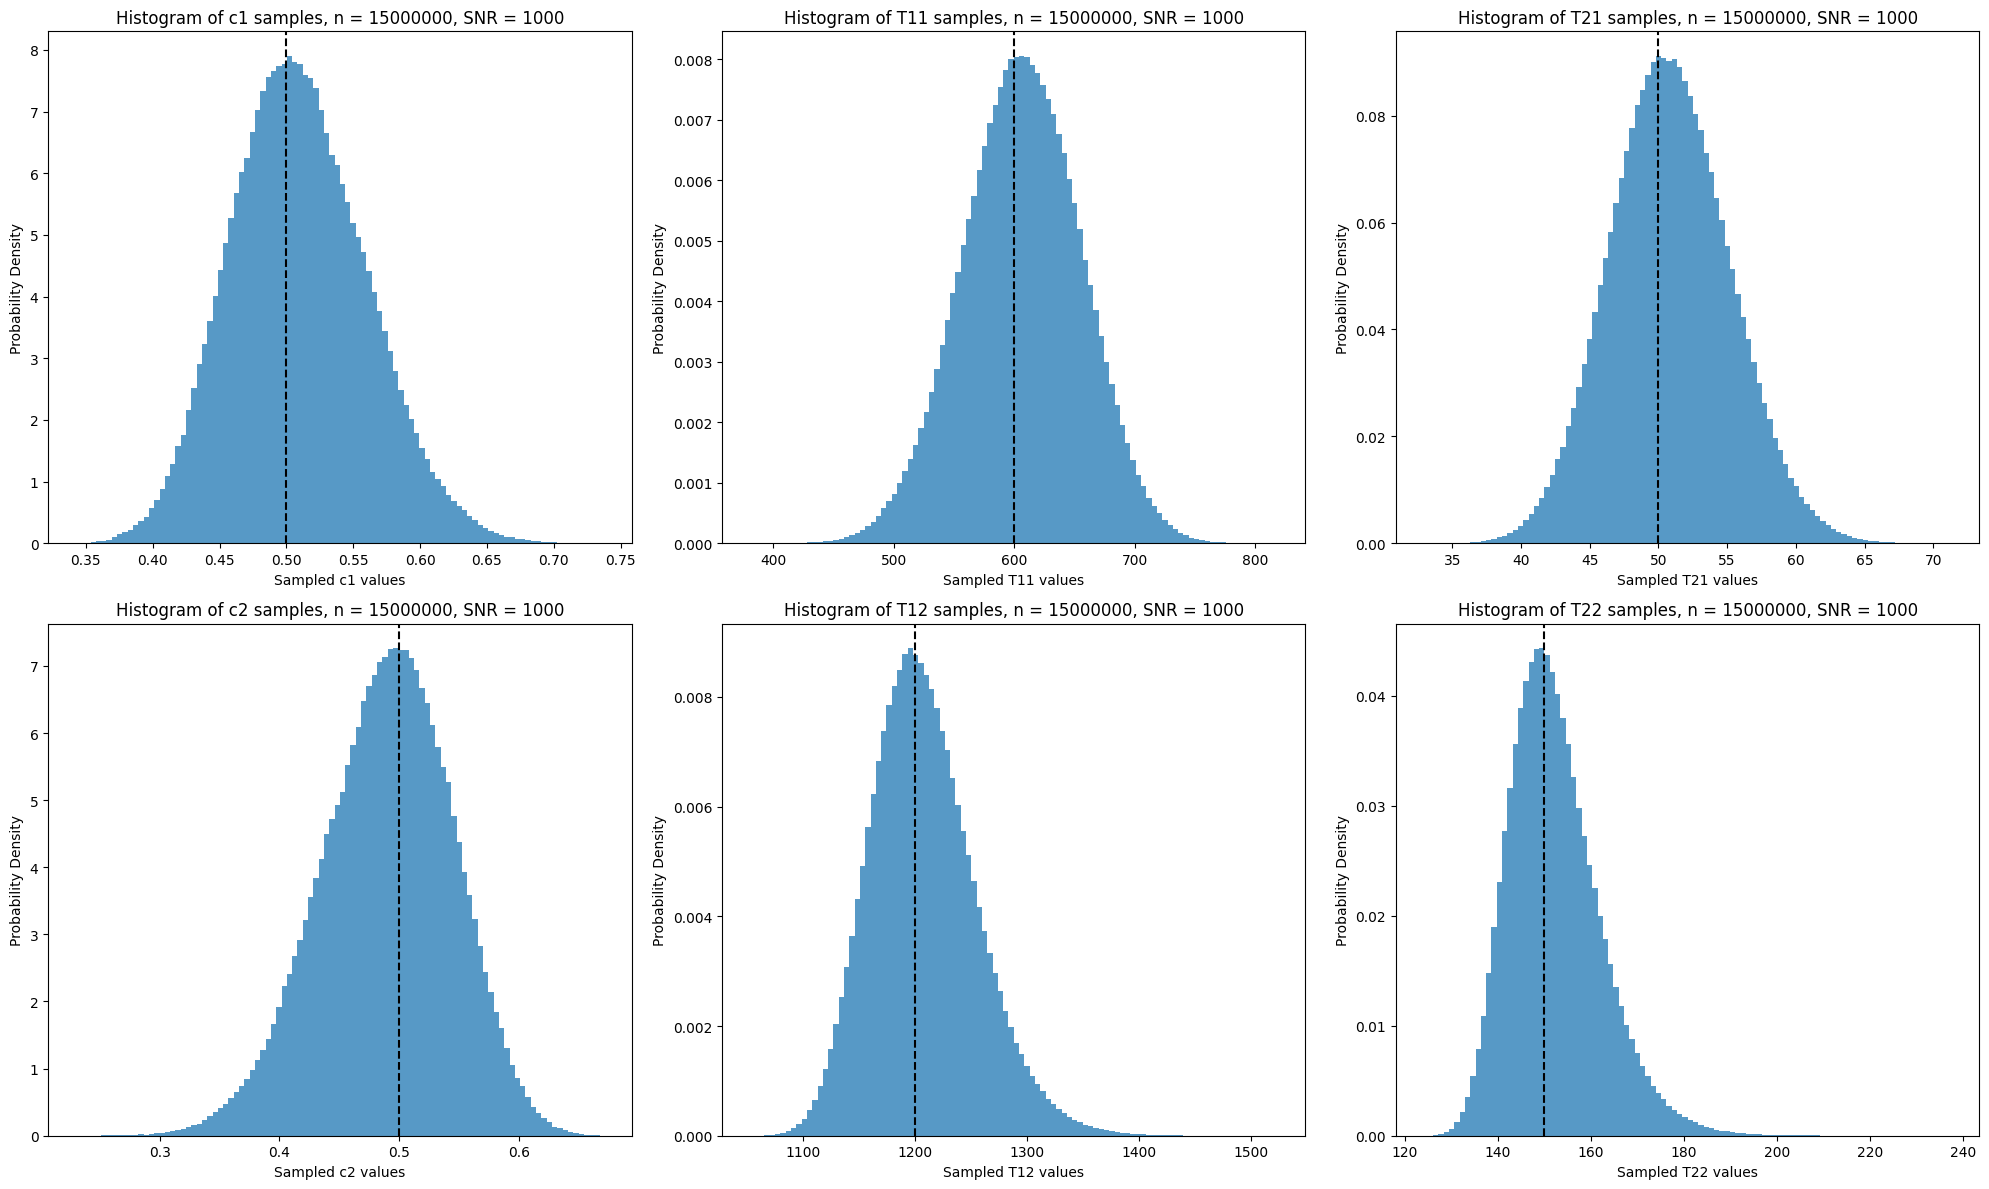

In [16]:
mjp_hold = max_joint_pdf(estimates)
print(f'Max of joint pdf at: {mjp_hold*np.array([1,1,t_norm,t_norm,t_norm,t_norm])}')
fig, ax = plt.subplots(2,3,figsize = (20, 12), tight_layout=True)
c1n, c1bins, c1patches = ax[0,0].hist(estimates[:,0], 100, density=True, alpha=0.75)
c1_estimate = c1bins[c1n.argmax()]
print('c1 estimate:', c1_estimate)
#ax[0,0].plot(c1_set, c1_function/integrate.simpson(c1_function, c1_set), label='Simpson Integration')
ax[0,0].set_xlabel('Sampled c1 values')
ax[0,0].set_ylabel('Probability Density')
ax[0,0].axvline(x = c1, ls = '--', color = 'k', label = 'true c1')
ax[0,0].set_title('Histogram of c1 samples, n = %s, SNR = %s' % (n_iterations, SNR))

c2n, c2bins, c2patches = ax[1,0].hist(estimates[:,1], 100, density=True, alpha=0.75)
c2_estimate = c2bins[c2n.argmax()]
print('c2 estimate:', c2_estimate)
ax[1,0].set_xlabel('Sampled c2 values')
ax[1,0].set_ylabel('Probability Density')
ax[1,0].axvline(x = c2, ls = '--', color = 'k', label = 'true c2')
ax[1,0].set_title('Histogram of c2 samples, n = %s, SNR = %s' % (n_iterations, SNR))

T11n, T11bins, T11patches = ax[0,1].hist(t_norm*estimates[:,2], 100, density=True, alpha=0.75)
T11_estimate = T11bins[T11n.argmax()]
print('T11 estimate:', T11_estimate)
ax[0,1].set_xlabel('Sampled T11 values')
ax[0,1].set_ylabel('Probability Density')
ax[0,1].axvline(x = T11, ls = '--', color = 'k', label = 'true T11')
ax[0,1].set_title('Histogram of T11 samples, n = %s, SNR = %s' % (n_iterations, SNR))

T12n, T12bins, T12patches = ax[1,1].hist(t_norm*estimates[:,3], 100, density=True, alpha=0.75)
T12_estimate = T12bins[T12n.argmax()]
print('T12 estimate:', T12_estimate)
ax[1,1].set_xlabel('Sampled T12 values')
ax[1,1].set_ylabel('Probability Density')
ax[1,1].axvline(x = T12, ls = '--', color = 'k', label = 'true T12')
ax[1,1].set_title('Histogram of T12 samples, n = %s, SNR = %s' % (n_iterations, SNR))

T21n, T21bins, T21patches = ax[0,2].hist(t_norm*estimates[:,4], 100, density=True, alpha=0.75)
T21_estimate = T21bins[T21n.argmax()]
print('T21 estimate:', T21_estimate)
#ax[0,2].plot(t_norm*T21_set, T21_function/integrate.simpson(T21_function, T21_set)/t_norm, label='Simpson Integration')
ax[0,2].set_xlabel('Sampled T21 values')
ax[0,2].set_ylabel('Probability Density')
ax[0,2].axvline(x = T21, ls = '--', color = 'k', label = 'true T21')
ax[0,2].set_title('Histogram of T21 samples, n = %s, SNR = %s' % (n_iterations, SNR))

T22n, T22bins, T22patches = ax[1,2].hist(t_norm*estimates[:,5], 100, density=True, alpha=0.75)
T22_estimate = T22bins[T22n.argmax()]
print('T22 estimate:', T22_estimate)
ax[1,2].set_xlabel('Sampled T22 values')
ax[1,2].set_ylabel('Probability Density')
ax[1,2].axvline(x = T22, ls = '--', color = 'k', label = 'true T22')
ax[1,2].set_title('Histogram of T22 samples, n = %s, SNR = %s' % (n_iterations, SNR))

plt.show()

# Define Metropolis Algorithm for Null Point Method

In [12]:
def initializeMH_np(joint_pdf, prior, verbose = False):
    c1 = np.random.uniform(0,c1_max)
    c2 = np.random.uniform(0,c2_max)
    T11 = np.random.uniform(0,T11_max)
    T12 = np.random.uniform(0,T12_max)
    T21 = np.random.uniform(0,T21_max)
    T22 = np.random.uniform(0,T22_max)
    iterator = 1
    while joint_pdf(TE_til_set,c1,c2,T11,T12,T21,T22)*prior(c1,c2,T11,T12,T21,T22) < 10**(-16):
        c1 = np.random.uniform(0,c1_max)
        c2 = np.random.uniform(0,c2_max)
        T11 = np.random.uniform(0,T11_max)
        T12 = np.random.uniform(0,T12_max)
        T21 = np.random.uniform(0,T21_max)
        T22 = np.random.uniform(0,T22_max)
        iterator += 1
    if verbose == True:
        print('Chose', iterator, 'different initial points')
        print('Initial points:', c1, c2, T11*t_norm, T12*t_norm, T21*t_norm, T22*t_norm)
    return (c1, c2, T11, T12, T21, T22)

def metropolis_np(likelihood, prior, transition_model, param_init, n_iterations, data, acceptance):
    #Set current values to the initial parameters
    c1_c, c2_c, T11_c, T12_c, T21_c, T22_c = param_init
    estimates = np.zeros((n_iterations,6))
    #rejections = []
    for n in trange(n_iterations):
        #Define the possible next step
        c1_temp, c2_temp, T11_temp, T12_temp, T21_temp, T22_temp = transition_model(c1_c, c2_c, T11_c, T12_c, T21_c, T22_c)
    
        r_current = prior(c1_c, c2_c, T11_c, T12_c, T21_c, T22_c)*likelihood(TE_til_set, c1_c, c2_c, T11_c, T12_c, T21_c, T22_c)
        r_temp = prior(c1_temp, c2_temp, T11_temp, T12_temp, T21_temp, T22_temp)*likelihood(TE_til_set, c1_temp, c2_temp, T11_temp, T12_temp, T21_temp, T22_temp)
        
        #Compare current position and possible next position, determine if we move or not
        if acceptance(r_current, r_temp):
            #If accepted, move to the new point. Otherwise, stay put
            c1_c, c2_c, T11_c, T12_c, T21_c, T22_c = c1_temp, c2_temp, T11_temp, T12_temp, T21_temp, T22_temp
        #else:
            #rejections.append(r_temp)
        estimates[n,:] = [c1_c, c2_c, T11_c, T12_c, T21_c, T22_c]
        
    return estimates

## Run Null Point Method Metropolis

### First run a burn-in time to randomize initial conditions

In [13]:
np.random.seed(1)
TI_np = 2*T11_til*np.log(2)
data_np = S(TI_np, TE_til, c1, c2, T11_til, T12_til, T21_til, T22_til) + noise_TE(noise_sd)
#param_init = (c1, c2, T11_til, T12_til, T21_til, T22_til)
joint_pdf_np = pdf_null_point(TI_np, data_np, noise_sd)

n_burnin = 1000000
burnin_init = initializeMH_np(joint_pdf_np, prior, verbose=True)
param_init_np = burnin(metropolis_np, joint_pdf_np,prior,transition_model, burnin_init, n_burnin, data_np, acceptance)
print('Burn in parameters:', param_init_np)

Chose 195216 different initial points
Initial points: 0.4741737663978227 0.8024996380762544 407.9301171778967 1427.8356742606547 54.107261561370244 71.28613195312909


 95%|█████████▌| 951797/1000000 [02:03<00:05, 8168.14it/s]C:\Users\griff\AppData\Local\Temp\ipykernel_1496\424828721.py:3: RuntimeWarning: overflow encountered in exp
  exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
C:\Users\griff\AppData\Local\Temp\ipykernel_1496\424828721.py:76: RuntimeWarning: overflow encountered in square
  residual = (data-model)**2
c:\co\NIA\.grif_venv\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
 95%|█████████▌| 953443/1000000 [02:03<00:06, 7300.66it/s]C:\Users\griff\AppData\Local\Temp\ipykernel_1496\424828721.py:77: RuntimeWarning: overflow encountered in double_scalars
  return np.exp(1/(n_TE)*-(1/(2*sd**2))*residual.sum())
100%|██████████| 1000000/1000000 [02:09<00:00, 7720.29it/s]

Burn in parameters: (0.2542418870849892, 0.004876431350399183, 0.012070524012927578, 0.45494408210040305, 0.016438067558164272, 0.04148183483113921)


### Use the endpoint of the burn-in time as the initial points, Run Metropolis

In [15]:
n_iterations = int(1.5*10**7)
np.random.seed(1)
TI_np = 1.4*T11_til*np.log(2)
data_np = S(TI_np, TE_til, c1, c2, T11_til, T12_til, T21_til, T22_til) + noise_TE(noise_sd)
joint_pdf_np = pdf_null_point(TI_np, data_np, noise_sd)

param_init_np = (c1, c2, T11_til, T12_til, T21_til, T22_til)
estimates_np = metropolis_np(joint_pdf_np,prior,transition_model, param_init_np, n_iterations, data_np, acceptance)

  7%|▋         | 975692/15000000 [01:16<16:33, 14118.39it/s]C:\Users\griff\AppData\Local\Temp\ipykernel_1496\424828721.py:76: RuntimeWarning: overflow encountered in square
  residual = (data-model)**2
C:\Users\griff\AppData\Local\Temp\ipykernel_1496\424828721.py:3: RuntimeWarning: overflow encountered in exp
  exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
  7%|▋         | 977113/15000000 [01:16<16:33, 14115.09it/s]C:\Users\griff\AppData\Local\Temp\ipykernel_1496\424828721.py:77: RuntimeWarning: overflow encountered in double_scalars
  return np.exp(1/(n_TE)*-(1/(2*sd**2))*residual.sum())
100%|██████████| 15000000/15000000 [28:24<00:00, 8801.80it/s] 


Max of joint pdf at: [2.44760513e-01 1.37307949e-01 4.34457908e+02 4.69927433e+03
 4.81741320e+01 1.48979970e+02]
c1 estimate: 0.2537510235870184
c2 estimate: 0.16564804035721079
T11 estimate: 687.8340065272977
T12 estimate: 3795.5080876789157
T21 estimate: 49.09658726917865
T22 estimate: 148.45805133975063


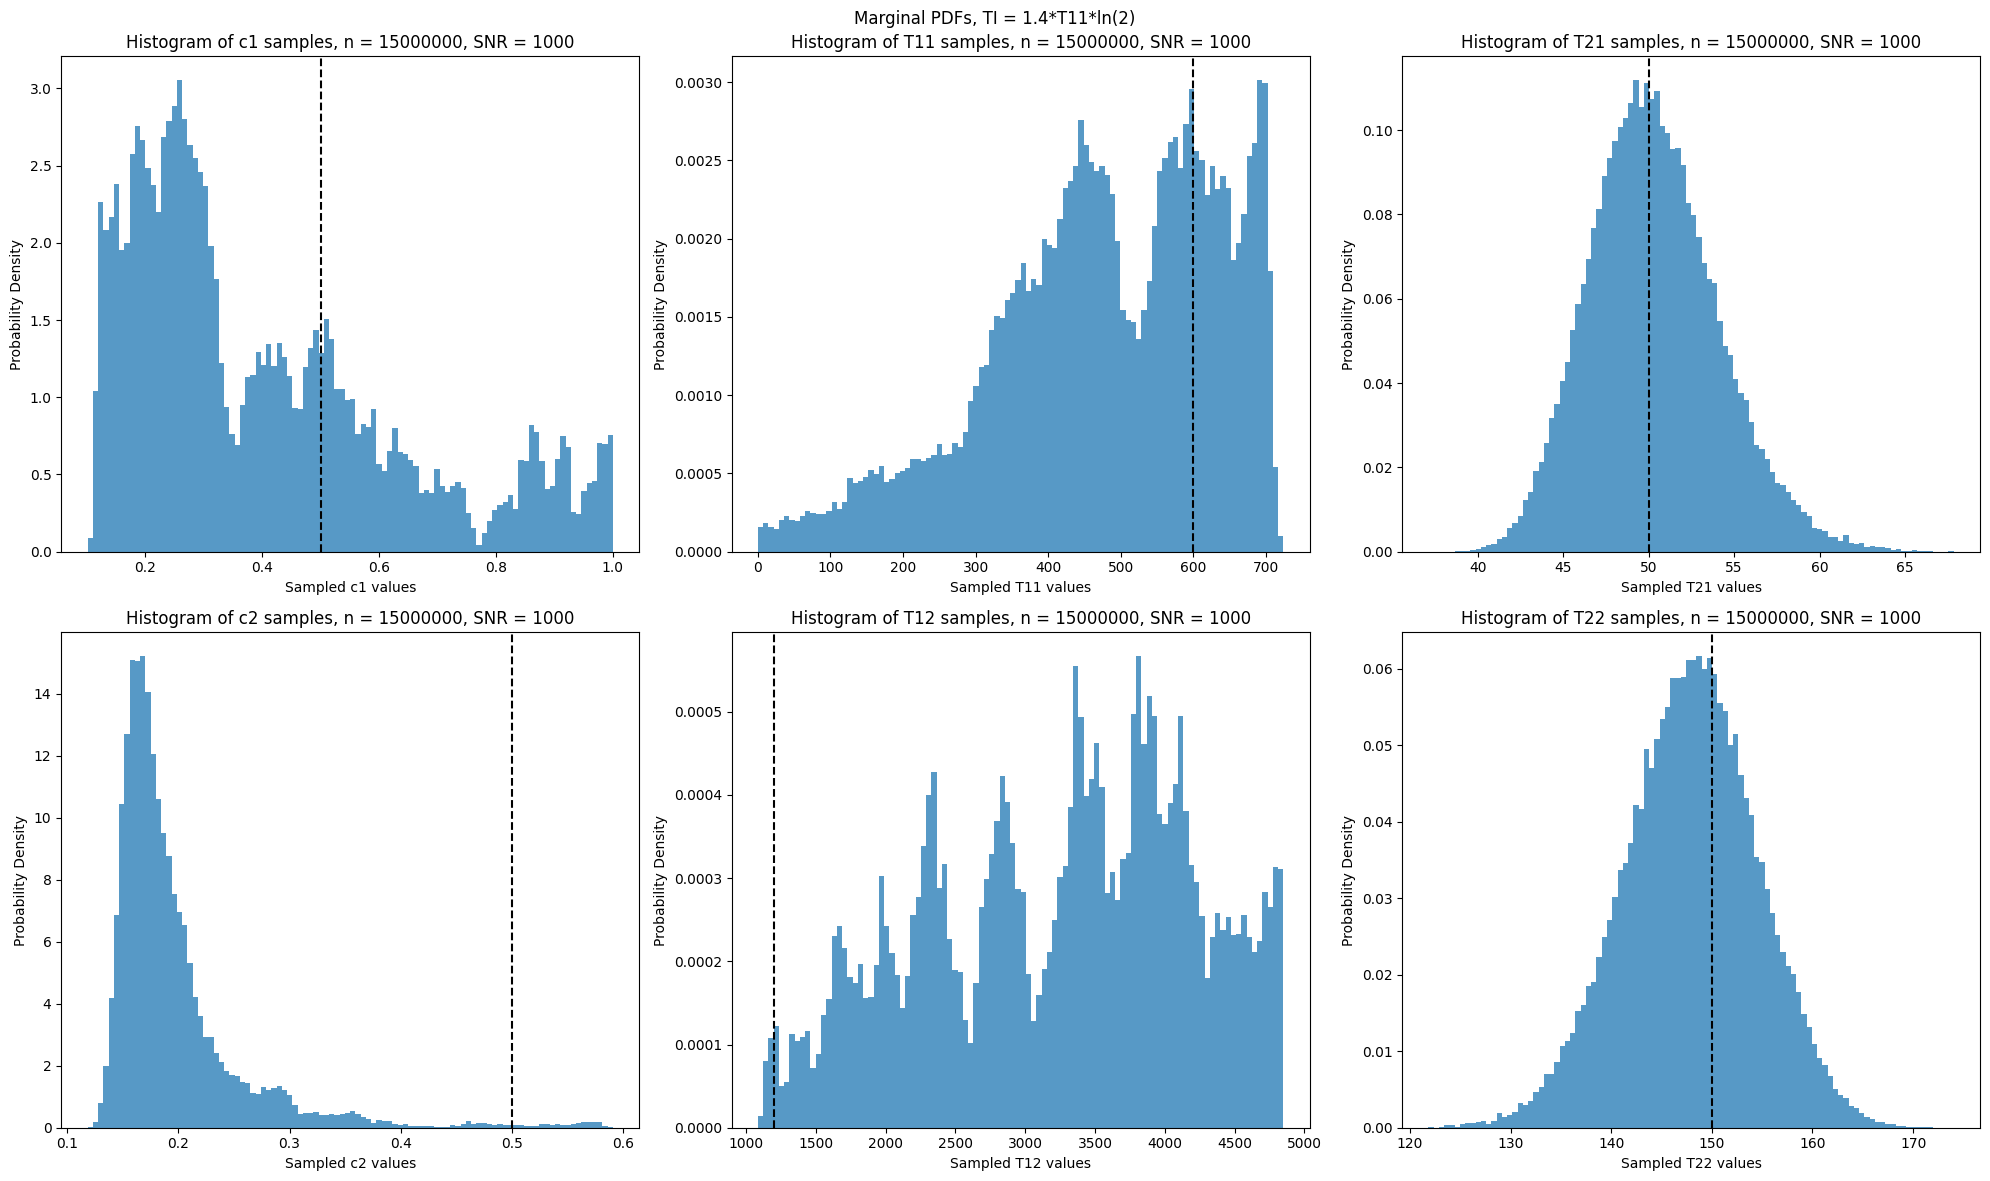

In [18]:
print('Max of joint pdf at:', max_joint_pdf(estimates_np)*np.array([1,1,t_norm,t_norm,t_norm,t_norm]))
fig, ax = plt.subplots(2,3,figsize = (20, 12), tight_layout=True)
fig.suptitle('Marginal PDFs, TI = 1.4*T11*ln(2)')
c1n, c1bins, c1patches = ax[0,0].hist(estimates_np[:,0], 100, density=True, alpha=0.75)
c1_estimate = c1bins[c1n.argmax()]
print('c1 estimate:', c1_estimate)
#ax[0,0].plot(c1_set, c1_function/integrate.simpson(c1_function, c1_set), label='Simpson Integration')
ax[0,0].set_xlabel('Sampled c1 values')
ax[0,0].set_ylabel('Probability Density')
ax[0,0].axvline(x = c1, ls = '--', color = 'k', label = 'true c1')
ax[0,0].set_title('Histogram of c1 samples, n = %s, SNR = %s' % (n_iterations, SNR))

c2n, c2bins, c2patches = ax[1,0].hist(estimates_np[:,1], 100, density=True, alpha=0.75)
c2_estimate = c2bins[c2n.argmax()]
print('c2 estimate:', c2_estimate)
ax[1,0].set_xlabel('Sampled c2 values')
ax[1,0].set_ylabel('Probability Density')
ax[1,0].axvline(x = c2, ls = '--', color = 'k', label = 'true c2')
ax[1,0].set_title('Histogram of c2 samples, n = %s, SNR = %s' % (n_iterations, SNR))

T11n, T11bins, T11patches = ax[0,1].hist(t_norm*estimates_np[:,2], 100, density=True, alpha=0.75)
T11_estimate = T11bins[T11n.argmax()]
print('T11 estimate:', T11_estimate)
ax[0,1].set_xlabel('Sampled T11 values')
ax[0,1].set_ylabel('Probability Density')
ax[0,1].axvline(x = T11, ls = '--', color = 'k', label = 'true T11')
ax[0,1].set_title('Histogram of T11 samples, n = %s, SNR = %s' % (n_iterations, SNR))

T12n, T12bins, T12patches = ax[1,1].hist(t_norm*estimates_np[:,3], 100, density=True, alpha=0.75)
T12_estimate = T12bins[T12n.argmax()]
print('T12 estimate:', T12_estimate)
ax[1,1].set_xlabel('Sampled T12 values')
ax[1,1].set_ylabel('Probability Density')
ax[1,1].axvline(x = T12, ls = '--', color = 'k', label = 'true T12')
ax[1,1].set_title('Histogram of T12 samples, n = %s, SNR = %s' % (n_iterations, SNR))

T21n, T21bins, T21patches = ax[0,2].hist(t_norm*estimates_np[:,4], 100, density=True, alpha=0.75)
T21_estimate = T21bins[T21n.argmax()]
print('T21 estimate:', T21_estimate)
#ax[0,2].plot(t_norm*T21_set, T21_function/integrate.simpson(T21_function, T21_set)/t_norm, label='Simpson Integration')
ax[0,2].set_xlabel('Sampled T21 values')
ax[0,2].set_ylabel('Probability Density')
ax[0,2].axvline(x = T21, ls = '--', color = 'k', label = 'true T21')
ax[0,2].set_title('Histogram of T21 samples, n = %s, SNR = %s' % (n_iterations, SNR))

T22n, T22bins, T22patches = ax[1,2].hist(t_norm*estimates_np[:,5], 100, density=True, alpha=0.75)
T22_estimate = T22bins[T22n.argmax()]
print('T22 estimate:', T22_estimate)
ax[1,2].set_xlabel('Sampled T22 values')
ax[1,2].set_ylabel('Probability Density')
ax[1,2].axvline(x = T22, ls = '--', color = 'k', label = 'true T22')
ax[1,2].set_title('Histogram of T22 samples, n = %s, SNR = %s' % (n_iterations, SNR))

plt.show()

# Metropolis using the 4 parameter null-point model

### Fix Parameters

d1, d2, di sum, and TI: 0.13212055882855767 -0.10653065971263342 0.02558989911592424 600


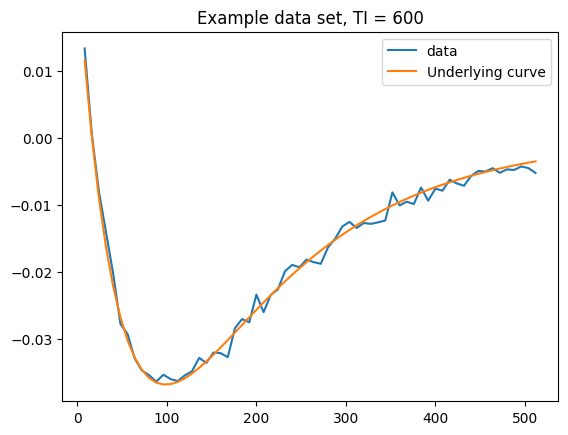

In [22]:
#Define a value of TI to perform Metropolis on
TI_np = 600
#Calculate the values of d1 and d2, given c1, c2, T11, and T12
d1 = c1*(1-2*np.exp(-TI_np/T11))
d2 = c2*(1-2*np.exp(-TI_np/T12))
di_sum = d1+d2
#Define step sizes for Metropolis for each of the parameters
#Will need to adjust based on SNR, parameters chosen, etc, but these general values seem to work well
step_d1 = 2/SNR
step_d2 = 2/SNR
step_T21 = 2*t_norm/SNR
step_T22 = 2*t_norm/SNR
#Define the box in which Metropolis will run
#Needed for the Bayesian prior
upper_bound_4P = np.array([1, 1, 300, 300])
lower_bound_4P = np.array([-1, -1, 0, 0])

print('d1, d2, di sum, and TI:', d1, d2, di_sum, TI_np)
#Set random seed for reproducibility
np.random.seed(0)
#Generate the data over TE with the given parameters
data_4P = S_4_param(TE_set, d1, d2, T21, T22) + noise_TE(noise_sd)
#Visualize the data
plt.plot(TE_set, data_4P, label='data')
plt.plot(TE_set, S_4_param(TE_set, d1, d2, T21, T22), label='Underlying curve')
plt.title('Example data set, TI = %s' % (TI_np))
plt.legend()
plt.show()

### Writing Metropololis 4p Functions

In [23]:
#This is the version of Metropolis used when working with the d model (reduced 4 parameter model)
def prior_4P(d1, d2, T21, T22):
    #Set the prior as a 4D box with probability of zero outside
    isGreater = np.array([d1,d2,T21,T22]) > upper_bound_4P
    isLower = np.array([d1,d2,T21,T22]) < lower_bound_4P
    for greater in isGreater:
        if greater == True:
            return 0
    for lower in isLower:
        if lower == True:
            return 0
    if T21>T22:
        return 0
    return 1

def initializeMH_4P(joint_pdf, prior, verbose = False):
    #Works as above initialization function, but joint_pdf is a function of TE, d1, d2, T21, and T22
    [d1_min, d2_min, T21_min, T22_min] = lower_bound_4P
    [d1_max, d2_max, T21_max, T22_max] = upper_bound_4P
    d1 = np.random.uniform(d1_min,d1_max)
    d2 = np.random.uniform(d2_min,d2_max)
    T21 = np.random.uniform(T21_min,T21_max)
    T22 = np.random.uniform(T22_min,T22_max)
    iterator = 1
    while joint_pdf(TE_set,d1,d2,T21,T22)*prior(d1,d2,T21,T22) < 10**(-16):
        d1 = np.random.uniform(d1_min,d1_max)
        d2 = np.random.uniform(d2_min,d2_max)
        T21 = np.random.uniform(T21_min,T21_max)
        T22 = np.random.uniform(T22_min,T22_max)
        iterator += 1
    if verbose == True:
        print('Chose', iterator, 'different initial points')
        print('Initial points:', d1, d2, T21, T22)
    return (d1, d2, T21, T22)

def transition_model_4P(d1, d2, T21, T22):
    #Given current values of the 4 parameters, returns where the next step will be
    dd1 = step_d1*np.random.normal(0,1)
    dd2 = step_d2*np.random.normal(0,1)
    dT21 = step_T21*np.random.normal(0,1)
    dT22 = step_T22*np.random.normal(0,1)
    
    return(d1+dd1, d2+dd2, T21+dT21, T22+dT22)

def transition_model_d_constrained(di_sum, d1, d2, T21, T22):
    #Same as above, but requires that d1+d2 = di_sum, a constant
    #We can do this because generally d1+d2 will be a constant for a given TI
    dd1 = step_d1*np.random.normal(0,1)
    #dd2 = di_sum - dd1
    dT21 = step_T21*np.random.normal(0,1)
    dT22 = step_T22*np.random.normal(0,1)
    
    return(d1+dd1, di_sum-(d1+dd1), T21+dT21, T22+dT22)

def acceptance_4P(r_current, r_temp):
    #returns true if new parameters are accepted
    #Basically same as above acceptance step
    if r_temp > r_current:
        return True
    else:
        accept = np.random.uniform(0,1)
        return (accept < r_temp/r_current)
    
def metropolis_4P(likelihood, prior, transition_model, param_init, n_iterations, data, acceptance,verbose=False):
    #Takes the likelihood function from pdf_np_4_param function, and other metropolis helper functions as defined above
    #param_init are the initial parameters for Metropolis-Hastings
    #n_iterations is how many total steps the algorithm will take
    #Set current values to the initial parameters
    d1_c, d2_c, T21_c, T22_c = param_init
    di_sum = d1_c + d2_c
    estimates = np.zeros((n_iterations,4))
    #rejections = []
    if verbose==False:
        for n in range(n_iterations):
            #Define the possible next step
            d1_temp, d2_temp, T21_temp, T22_temp = transition_model(di_sum, d1_c, d2_c, T21_c, T22_c)#transition_model(d1_c, d2_c, T21_c, T22_c)
    
            r_current = prior(d1_c, d2_c, T21_c, T22_c)*likelihood(TE_set, d1_c, d2_c, T21_c, T22_c)
            r_temp = prior(d1_temp, d2_temp, T21_temp, T22_temp)*likelihood(TE_set, d1_temp, d2_temp, T21_temp, T22_temp)
        
            #Compare current position and possible next position, determine if we move or not
            if acceptance(r_current, r_temp):
                #If accepted, move to the new point. Otherwise, stay put
                d1_c, d2_c, T21_c, T22_c = d1_temp, d2_temp, T21_temp, T22_temp
            #else:
                #rejections.append(r_temp)
            estimates[n,:] = [d1_c, d2_c, T21_c, T22_c]
    if verbose==True:
        for n in trange(n_iterations):
            #Define the possible next step
            d1_temp, d2_temp, T21_temp, T22_temp = transition_model(di_sum, d1_c, d2_c, T21_c, T22_c)#transition_model(d1_c, d2_c, T21_c, T22_c)
    
            r_current = prior(d1_c, d2_c, T21_c, T22_c)*likelihood(TE_set, d1_c, d2_c, T21_c, T22_c)
            r_temp = prior(d1_temp, d2_temp, T21_temp, T22_temp)*likelihood(TE_set, d1_temp, d2_temp, T21_temp, T22_temp)
        
            #Compare current position and possible next position, determine if we move or not
            if acceptance(r_current, r_temp):
                #If accepted, move to the new point. Otherwise, stay put
                d1_c, d2_c, T21_c, T22_c = d1_temp, d2_temp, T21_temp, T22_temp
            #else:
                #rejections.append(r_temp)
            estimates[n,:] = [d1_c, d2_c, T21_c, T22_c]       
        
    return estimates    

def burnin_4P(metropolis, likelihood, prior, transition_model, param_init, n_iterations, data, acceptance):
    #Start by running a "burn-in" time of n_iterations
    burnin = metropolis(likelihood, prior, transition_model, param_init, n_iterations, data, acceptance)

    return tuple(burnin[n_iterations-1,:])

def mirror_metropolis_4P(metropolis, likelihood, prior, transition_model, param_init, n_burnin,n_iterations, data, acceptance, verbose=False):
    #Runs metropolis starting from the initial parameters, then flips the parameter labels to get the 45-degree mirror image
    #Generally joint PDFs will be mirrored in T21-T22 and d1-d2
    d1_init, d2_init, T21_init, T22_init = param_init
    param_init_1 = (d1_init, d2_init, T21_init, T22_init)
    param_init_2 = (d2_init, d1_init, T22_init, T21_init)
    
    #Runs two burnin times, one for each of the mirrored initial parameters
    burnin_init_1 = burnin_4P(metropolis,likelihood,prior,transition_model, param_init_1, n_burnin, data, acceptance)
    burnin_init_2 = burnin_4P(metropolis,likelihood,prior,transition_model, param_init_2, n_burnin, data, acceptance)
    
    #Runs metropolis twice on the data set, one for each of the mirrored initial parameters
    estimates_1 = metropolis_4P(likelihood,prior,transition_model, burnin_init_1, n_iterations, data, acceptance, verbose=verbose)
    estimates_2 = metropolis_4P(likelihood,prior,transition_model, burnin_init_2, n_iterations, data, acceptance, verbose=verbose)
    
    estimates_comb = np.append(estimates_1, estimates_2, axis=0)
    
    return estimates_comb

def get_NLLS_estimates_4P(d1, d2, T21, T22, n_iterations, p0):
    #Given a set of 4 parameters, iterates through n_iterations noise realizations and performs NLLS initialized at p0
    #Returns the set of estimates, a (n_iterations x 4) matrix
    underlying = S_4_param(TE_set, d1, d2, T21, T22)
    estimates = np.zeros((n_iterations, 4))
    for n in range(n_iterations):
        np.random.seed(n)
        data = underlying + noise_TE(noise_sd)
        
        est = estimate_NLLS(S_4_param, TE_set, data, p0 = p0)
        estimates[n,:] = est
    
    return estimates

### Run Metropolois for 4 Parameters

In [25]:
#Get the joint posterior as a function of the parameters
#Metropolis-Hastings will sample this function
joint_pdf_4P = pdf_np_4_param(data_4P, noise_sd)

#Define number of iterations and initial starting point
n_iterations = int(2.5*10**7)
d1_init = d1
d2_init = di_sum - d1_init
param_init_4P = (d1_init, d2_init, T21, T22)
#Save metropolis steps as estimates_4P, an (n_iterations x 4) matrix
#To run Metropolis, enter the joint PDF you would like to sample, 
#the prior, transition model, initial parameters, number of steps, noisy data, and acceptance step
#Verbose=True will give a progress bar, verbose=False will not give the progress bar
estimates_4P = metropolis_4P(joint_pdf_4P,prior_4P,transition_model_d_constrained, 
                             param_init_4P, n_iterations, data_4P, acceptance_4P, verbose=True)

100%|██████████| 25000000/25000000 [44:09<00:00, 9435.98it/s] 


### Graph 4 Parameter Metropolis

In [28]:
#This will allow you to load data into dset and visualize it
# with h5py.File(f'MetRuns//Metropolis_T11_{T11}_T12{T12}_T21_{T21}_T22_{T22}_SNR_{SNR}_numRuns_31Oct22.hdf5','a') as f2:
#     TI_np = 860.0
#     d1 = c1*(1-2*np.exp(-(TI_np)/T11))
#     d2 = c2*(1-2*np.exp(-(TI_np)/T12))
#     TI_lbl = str(TI_np)
#     dset = np.array(f2[TI_lbl])

In [30]:
#This is for if you include the constraint T21 < T22 in the data, but wish to symmetrize the PDF
graphing_data = estimates_4P #dset.copy()
gd_mirror = np.zeros(graphing_data.shape)
gd_mirror[:,0] = graphing_data[:,1]
gd_mirror[:,1] = graphing_data[:,0]
gd_mirror[:,2] = graphing_data[:,3]
gd_mirror[:,3] = graphing_data[:,2]
graphing_data = np.append(graphing_data, gd_mirror, axis=0)

d1 estimate: -0.10566888080708181
d2 estimate: -0.10566888080708181
T21 estimate: 77.92708129775367
T22 estimate: 77.92708129775367


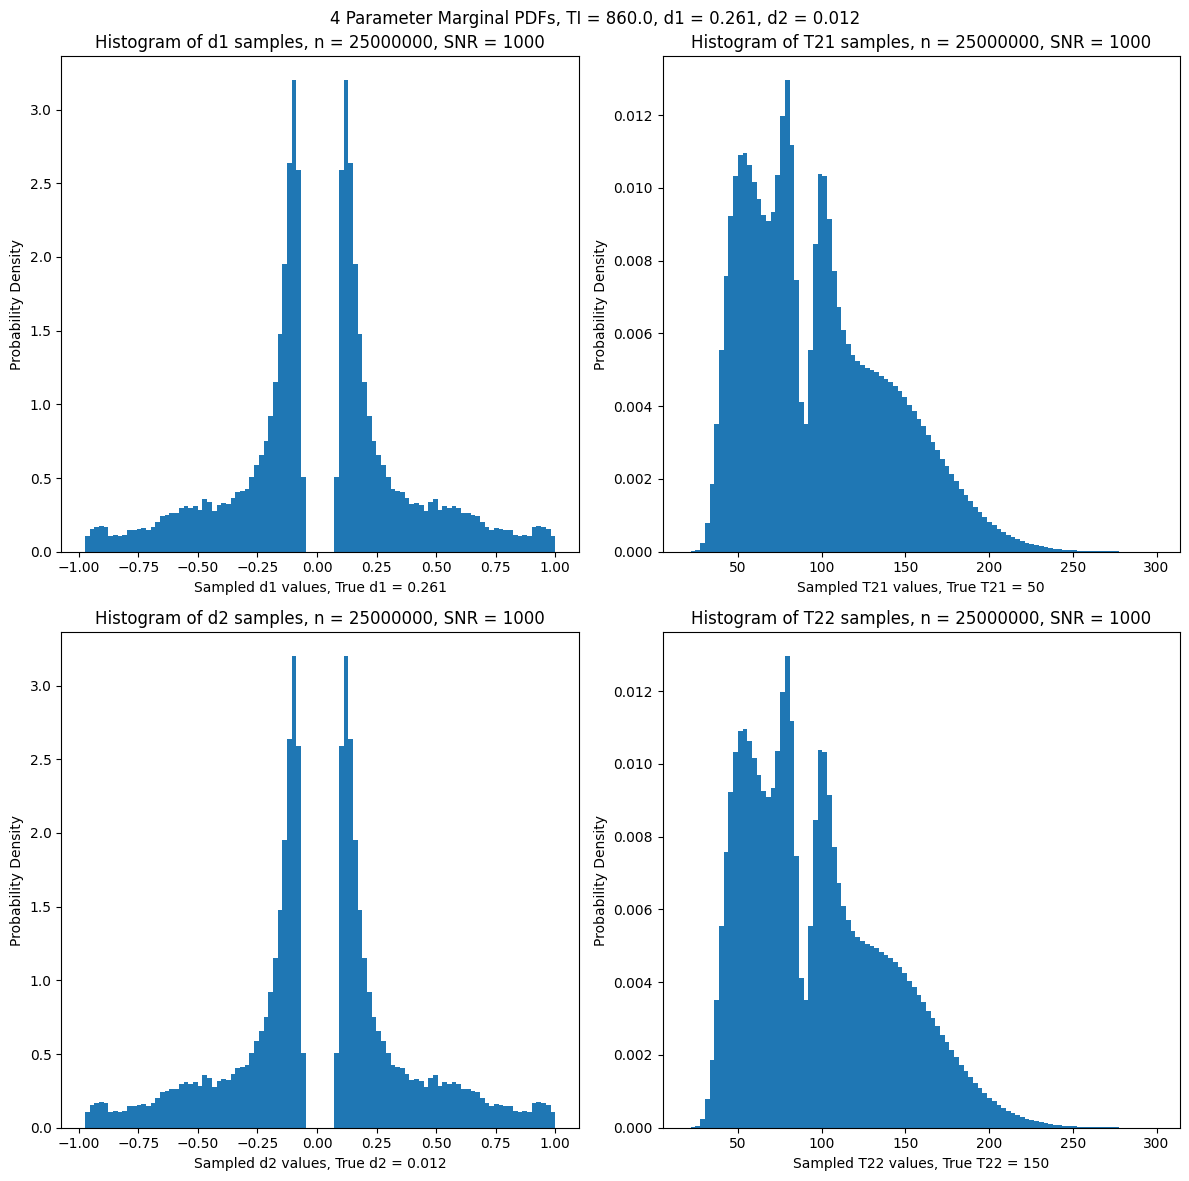

In [31]:
#Visualizes the marginal PDFs of the 4 variables
fig, ax = plt.subplots(2,2,figsize = (12, 12), tight_layout=True)
fig.suptitle('4 Parameter Marginal PDFs, TI = %s, d1 = %s, d2 = %s'%(TI_np,round(d1, 3), round(d2,3)))
d1n, d1bins, d1patches = ax[0,0].hist(graphing_data[:,0], 100, density=True)
d1_estimate = d1bins[d1n.argmax()]
print('d1 estimate:', d1_estimate)
ax[0,0].set_xlabel('Sampled d1 values, True d1 = %s'%round(d1, 3))
ax[0,0].set_ylabel('Probability Density')
ax[0,0].set_title('Histogram of d1 samples, n = %s, SNR = %s' % (n_iterations, SNR))

d2n, d2bins, d2patches = ax[1,0].hist(graphing_data[:,1], 100, density=True)
d2_estimate = d2bins[d2n.argmax()]
print('d2 estimate:', d2_estimate)
ax[1,0].set_xlabel('Sampled d2 values, True d2 = %s'%round(d2,3))
ax[1,0].set_ylabel('Probability Density')
ax[1,0].set_title('Histogram of d2 samples, n = %s, SNR = %s' % (n_iterations, SNR))

T21n, T21bins, T21patches = ax[0,1].hist(graphing_data[:,2], 100, density=True)
T21_estimate = T21bins[T21n.argmax()]
print('T21 estimate:', T21_estimate)
#ax[0,1].set_ylim([0,6])
ax[0,1].set_xlabel('Sampled T21 values, True T21 = %s'%(T21))
ax[0,1].set_ylabel('Probability Density')
ax[0,1].set_title('Histogram of T21 samples, n = %s, SNR = %s' % (n_iterations, SNR))

T22n, T22bins, T22patches = ax[1,1].hist(graphing_data[:,3], 100, density=True)
T22_estimate = T22bins[T22n.argmax()]
print('T22 estimate:', T22_estimate)
#ax[1,1].set_ylim([0,0.001])
ax[1,1].set_xlabel('Sampled T22 values, True T22 = %s'%(T22))
ax[1,1].set_ylabel('Probability Density')
ax[1,1].set_title('Histogram of T22 samples, n = %s, SNR = %s' % (n_iterations, SNR))

plt.show()

#### Graph the Joint PDFs of 4 Parameter Metropolis

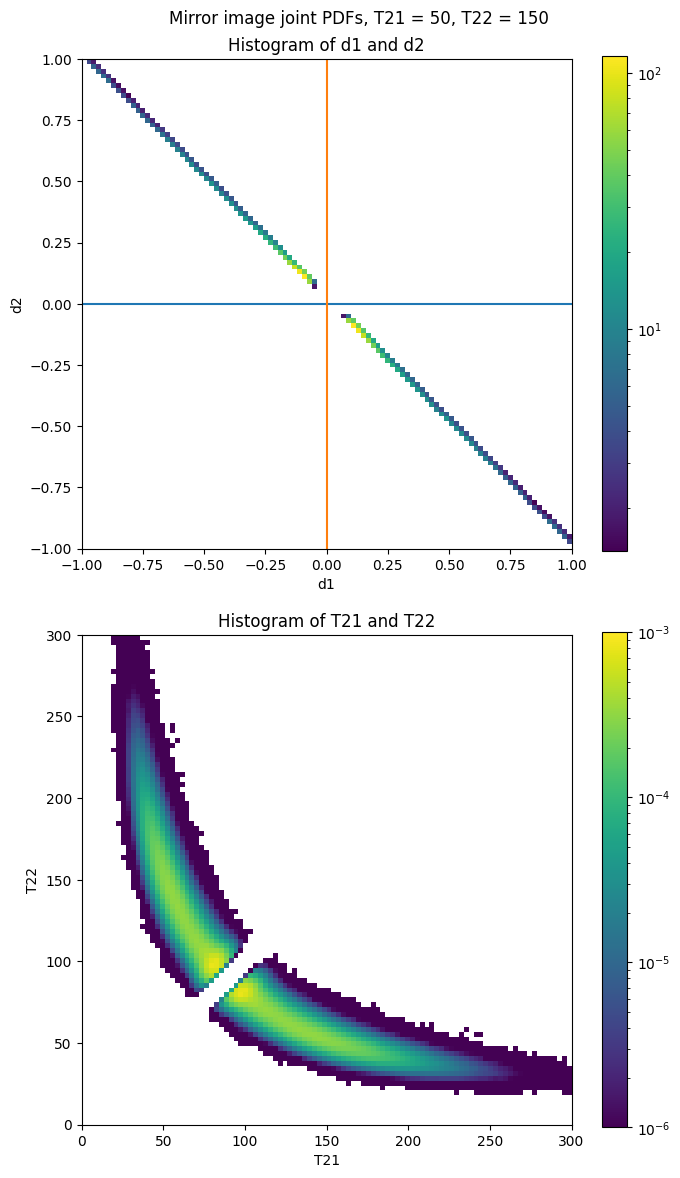

In [32]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(7,12),tight_layout=True)
fig.suptitle('Mirror image joint PDFs, T21 = %s, T22 = %s'%(T21, T22))
ax1.set_aspect('equal')
ax2.set_aspect('equal')

hh1 = ax1.hist2d(graphing_data[:,0], graphing_data[:,1], 
                 norm=mpl.colors.LogNorm(), bins=100, density=True,range=([-1,1],[-1,1]))
ax1.set_title('Histogram of d1 and d2')
ax1.set_xlabel('d1')
ax1.set_ylabel('d2')
ax1.plot(np.linspace(-1,1,10), [0]*10)
ax1.plot([0]*10, np.linspace(-1,1,10))

hh2 = ax2.hist2d(graphing_data[:,2], graphing_data[:,3], 
                 norm=mpl.colors.LogNorm(vmin=10**(-6),vmax=10**(-3)), bins=100, density=True,range=([0,300],[0,300]))
ax2.set_title('Histogram of T21 and T22')
ax2.set_xlabel('T21')
ax2.set_ylabel('T22')

fig.colorbar(hh1[3], ax=ax1)
fig.colorbar(hh2[3], ax=ax2)

plt.show()

### Iterate through TI values with 4 Parameter Metropolis

In [33]:
#Define number of iterations and the set through which you will iterate
n_iterations = 50000000

TI_set = np.linspace(420, 540, 25)

start_time = time.time()
#Saves the dataset as an hdf5 file which can be retrieved later for analysis
#Each data set will be labeled by TI value
with h5py.File(f'MetRuns//Metropolis_T11_{T11}_T12{T12}_T21_{T21}_T22_{T22}_SNR_{SNR}_upRes_31Oct22.hdf5','a') as f:
    for TI_idx in trange(len(TI_set)):
        TI_i = TI_set[TI_idx]
        #Iterate through the set of TI values, looking for the null points in the data
        d1 = c1*(1-2*np.exp(-TI_i/T11))
        d2 = c2*(1-2*np.exp(-TI_i/T12))
        di_sum = d1+d2
        #Generate the data and calculate the Bayesian Posterior PDF
        np.random.seed(0)
        data_4P = S_4_param(TE_set, d1, d2, T21, T22) + noise_TE(noise_sd)
        joint_pdf_4P = pdf_np_4_param(data_4P, noise_sd)
        #Set the initial values for the burnin times and run metropolis on the PDF
        d1_init = d1
        d2_init = di_sum - d1_init
        burnin_init_4P = (d1_init, d2_init, T21, T22)

        estimates_4P = metropolis_4P(joint_pdf_4P,prior_4P,transition_model_d_constrained, 
                             burnin_init_4P, n_iterations, data_4P, acceptance_4P, verbose=False)
        #estimates_NLLS = get_NLLS_estimates_4P(d1, d2, T21, T22, n_iterations, burnin_init_4P)
        #Save the data set
        dset = f.create_dataset('%s'%(TI_i),data=estimates_4P)

        if TI_idx<5:
            print(f.keys())
print(time.time()-start_time, 'seconds')

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\griff\AppData\Local\Temp\ipykernel_1496\424828721.py:86: RuntimeWarning: overflow encountered in square
  residual = (data-model)**2
C:\Users\griff\AppData\Local\Temp\ipykernel_1496\424828721.py:18: RuntimeWarning: overflow encountered in exp
  model = d1*np.exp(-TE/T21)+d2*np.exp(-TE/T22)
C:\Users\griff\AppData\Local\Temp\ipykernel_1496\424828721.py:87: RuntimeWarning: overflow encountered in double_scalars
  return np.exp(1/(n_TE)*-(1/(2*sd**2))*residual.sum())
  0%|          | 0/25 [02:00<?, ?it/s]


KeyboardInterrupt: 

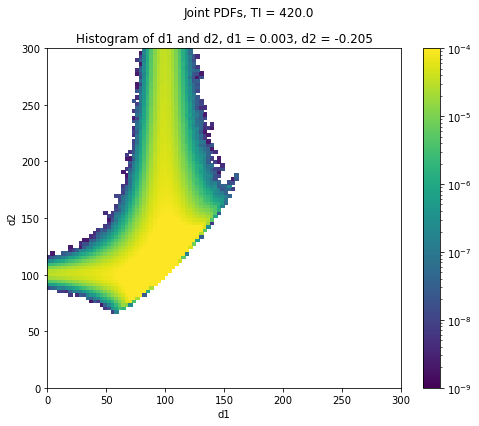

In [ ]:
#Retrieve a dataset for visualization
start_time = time.time()
with h5py.File('Metropolis Runs//Metropolis 600 1200 45 100 SNR 1000 5e7 runs d constrained 5-9.hdf5','a') as f2:
    TI_np = 420.0
    d1 = c1*(1-2*np.exp(-(TI_np)/T11))
    d2 = c2*(1-2*np.exp(-(TI_np)/T12))
    TI_lbl = str(TI_np)
    dset = np.array(f2[TI_lbl])
#CODE FOR DISPLAYING JUST THE PDFs
fig, ax = plt.subplots(figsize=(7,6),tight_layout=True)
fig.suptitle('Joint PDFs, TI = %s'%(TI_np))
ax.set_title('Histogram of d1 and d2, d1 = %s, d2 = %s'%(round(d1,3), round(d2,3)))
#ax.set_aspect('equal')
hh = ax.hist2d(dset[:,2], dset[:,3],
               norm=mpl.colors.LogNorm(vmin=10**(-9), vmax=10**(-4)), bins=100, density=True,range=([0,300],[0,300]))
ax.set_xlabel('d1')
ax.set_ylabel('d2')
fig.colorbar(hh[3], ax=ax)
plt.show()

In [ ]:
with h5py.File('Metropolis Runs//Metropolis 400 2000 20 200 SNR 1000 5e7 runs d constrained 5-10.hdf5','r') as f1:
    keys = list(f1.keys())
    #print(keys)
    for k in trange(len(keys)):
        TI_np = int(float(keys[k]))
        key = keys[k]
        dset = f1[key]
        dset = dset[:]
        graphing_data = dset.copy()
        gd_mirror = np.zeros(graphing_data.shape)
        gd_mirror[:,0] = graphing_data[:,1]
        gd_mirror[:,1] = graphing_data[:,0]
        gd_mirror[:,2] = graphing_data[:,3]
        gd_mirror[:,3] = graphing_data[:,2]
        graphing_data = np.append(graphing_data, gd_mirror, axis=0)
            
        d_joint = np.histogram2d(graphing_data[:,0], graphing_data[:,1], bins=100, range=([-1,1],[-1,1]), density=True)
        T2_joint = np.histogram2d(graphing_data[:,2], graphing_data[:,3], bins=100, range=([0,300],[0,300]), density=True)
        d1_marginal = np.histogram(graphing_data[:,0], bins=100, range=[-1,1], density=True)
        d2_marginal = np.histogram(graphing_data[:,1], bins=100, range=[-1,1], density=True)
        T21_marginal = np.histogram(graphing_data[:,2], bins=100, range=[0,300], density=True)
        T22_marginal = np.histogram(graphing_data[:,3], bins=100, range=[0,300], density=True)
        
        #with h5py.File('Bayesian Joint PDFs//Raw Metropolis Data 600 1200 45 100 SNR 1000 d constrained 1e8 runs 5-9-22.hdf5','a') as f2:
            #raw_metropolis = f2.create_dataset('%s'%TI_np, data=graphing_data)
        with h5py.File('Bayesian Joint PDFs//2D Joint PDFs 400 2000 20 200 SNR 1000 1e8 runs d constrained 5-10-22.hdf5','a') as f2:
            d_joint_data = f2.create_dataset('%s d1 d2'%TI_np, data=d_joint[0])
            T2_joint_data = f2.create_dataset('%s T21 T22'%TI_np, data=T2_joint[0])
        with h5py.File('Bayesian Joint PDFs//Marginal PDFs 400 2000 20 200 SNR 1000 1e8 runs d constrained 5-10-22.hdf5','a') as f2:
            d1_marg_data = f2.create_dataset('%s d1'%TI_np, data=d1_marginal[0])
            d2_marg_data = f2.create_dataset('%s d2'%TI_np, data=d2_marginal[0])
            T21_marg_data = f2.create_dataset('%s T21'%TI_np, data=T21_marginal[0])
            T22_marg_data = f2.create_dataset('%s T22'%TI_np, data=T22_marginal[0])

 96%|██████████████████████████████████████████████████████████████████████████████▍   | 22/23 [06:42<00:17, 17.11s/it]

In [ ]:
print(d1_marginal[1])

[-1.   -0.98 -0.96 -0.94 -0.92 -0.9  -0.88 -0.86 -0.84 -0.82 -0.8  -0.78
 -0.76 -0.74 -0.72 -0.7  -0.68 -0.66 -0.64 -0.62 -0.6  -0.58 -0.56 -0.54
 -0.52 -0.5  -0.48 -0.46 -0.44 -0.42 -0.4  -0.38 -0.36 -0.34 -0.32 -0.3
 -0.28 -0.26 -0.24 -0.22 -0.2  -0.18 -0.16 -0.14 -0.12 -0.1  -0.08 -0.06
 -0.04 -0.02  0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16  0.18
  0.2   0.22  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38  0.4   0.42
  0.44  0.46  0.48  0.5   0.52  0.54  0.56  0.58  0.6   0.62  0.64  0.66
  0.68  0.7   0.72  0.74  0.76  0.78  0.8   0.82  0.84  0.86  0.88  0.9
  0.92  0.94  0.96  0.98  1.  ]


In [ ]:
print(T21_marginal[1])

[  0.   3.   6.   9.  12.  15.  18.  21.  24.  27.  30.  33.  36.  39.
  42.  45.  48.  51.  54.  57.  60.  63.  66.  69.  72.  75.  78.  81.
  84.  87.  90.  93.  96.  99. 102. 105. 108. 111. 114. 117. 120. 123.
 126. 129. 132. 135. 138. 141. 144. 147. 150. 153. 156. 159. 162. 165.
 168. 171. 174. 177. 180. 183. 186. 189. 192. 195. 198. 201. 204. 207.
 210. 213. 216. 219. 222. 225. 228. 231. 234. 237. 240. 243. 246. 249.
 252. 255. 258. 261. 264. 267. 270. 273. 276. 279. 282. 285. 288. 291.
 294. 297. 300.]


In [ ]:
#Go through one of the iterating TI files and calculate several statistical quantities for each TI
#Variances of T21, T22, d1, d2, S21, and S22
#S21 is defined as the tanh of T21
T21_var_list = []
T22_var_list = []
d1_var_list = []
d2_var_list = []
d1_range_list = []
d2_range_list = []
S21_var_list = []
S22_var_list = []
joint_max_list = []
with h5py.File('Metropolis Runs//Metropolis 600 1200 45 100 SNR 1000 5e7 runs d constrained 5-9.hdf5','a') as f2:
    keys = list(f2.keys())
    print(keys)
    for k in trange(len(keys)):
        key = keys[k]
        dset = f2[key]
        dset = dset[:]
        graphing_data = dset.copy()
        gd_mirror = np.zeros(graphing_data.shape)
        gd_mirror[:,0] = graphing_data[:,1]
        gd_mirror[:,1] = graphing_data[:,0]
        gd_mirror[:,2] = graphing_data[:,3]
        gd_mirror[:,3] = graphing_data[:,2]
        graphing_data = np.append(graphing_data, gd_mirror, axis=0)
        
        H, edges = np.histogramdd(graphing_data, bins=100)
        joint_max_val = np.max(H)
        joint_max_list.append(joint_max_val)
        
        d1_var_list.append(np.var(graphing_data[:,0]))
        d2_var_list.append(np.var(graphing_data[:,1]))
        T21_var_list.append(np.var(graphing_data[:,2]))
        T22_var_list.append(np.var(graphing_data[:,3]))
        
        d1_range = np.max(graphing_data[:,0]) - np.min(graphing_data[:,0])
        d2_range = np.max(graphing_data[:,1]) - np.min(graphing_data[:,1])
        d1_range_list.append(d1_range)
        d2_range_list.append(d2_range)
        
        S21 = np.tanh(graphing_data[:,2]/45)
        S21_var = np.var(S21)
        S21_var_list.append(S21_var)
        
        S22 = np.tanh(graphing_data[:,3]/100)
        S22_var = np.var(S22)
        S22_var_list.append(S22_var)

  0%|                                                                                           | 0/34 [00:00<?, ?it/s]

['300.0', '320.0', '340.0', '360.0', '380.0', '400.0', '420.0', '440.0', '460.0', '480.0', '500.0', '520.0', '540.0', '560.0', '580.0', '600.0', '620.0', '640.0', '660.0', '680.0', '700.0', '720.0', '740.0', '760.0', '780.0', '800.0', '820.0', '840.0', '860.0', '880.0', '900.0', '920.0', '940.0', '960.0']


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [16:31<00:00, 29.16s/it]


No handles with labels found to put in legend.


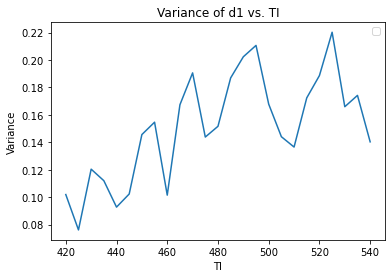

In [ ]:
plt.plot(TI_np_set,np.array(d1_var_list))
plt.title('Variance of d1 vs. TI')
plt.xlabel('TI')
plt.ylabel('Variance')
#plt.ylim(0,150)
#plt.axvline(x=415, label = 'TI*1 = 415', color='r')
#plt.axvline(x=831, label = 'TI*2 = 830', color='g')
plt.legend()
plt.show()

### Using iterative TI method above, perform monoexponential NLLS to get estimates for d_i and T2_i

In [ ]:
TI_til_null_est = 855/t_norm
d1 = c1*(1-2*np.exp(-TI_til_null_est/T11_til))
d2 = c2*(1-2*np.exp(-TI_til_null_est/T12_til))
data_4D = S_4D(TE_til_set, d1, d2, T21_til, T22_til) + noise_TE(noise_sd)

est_ME = estimate_NLLS(S_ME, TE_til_set, data_4D)
print(est_ME[0], est_ME[1]*t_norm)

0.2670063438068877 46.79406720975372


### For a given set of 4 parameters, perform NLLS over many noise realizations

In [ ]:
TI_null_NLLS = 600
d1 = c1*(1-2*np.exp(-TI_null_NLLS/T11))
d2 = c2*(1-2*np.exp(-TI_null_NLLS/T12))

n_iterations = 100000
p0 = [d1,d2,T21,T22]

estimates_4P_NLLS = get_NLLS_estimates_4P(d1, d2, T21, T22, n_iterations, p0)

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [08:23<00:00, 198.63it/s]


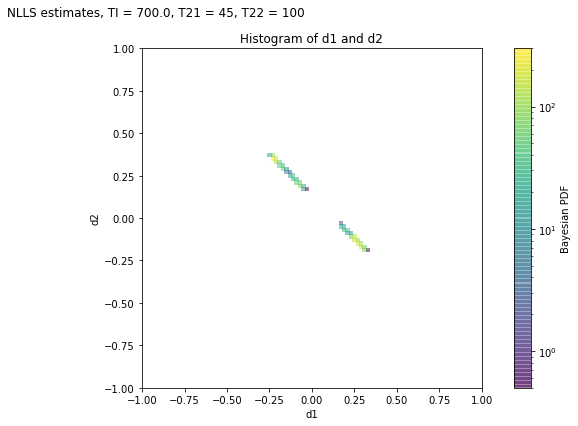

In [ ]:
TI_np = 700.0
TI_lbl = str(TI_np)
with h5py.File('Metropolis Runs//Metropolis 45 100 iterate TI 2-18.hdf5','a') as f1:
    dset_bayes = np.array(f1[TI_lbl])
with h5py.File('Metropolis Runs//NLLS 600 1200 45 100 SNR 1000 4-3.hdf5','a') as f2:
    dset_NLLS = np.array(f2[TI_lbl])
fig, ax = plt.subplots(figsize=(12,6),tight_layout=True)
fig.suptitle('NLLS estimates, TI = %s, T21 = %s, T22 = %s'%(TI_np, T21, T22))

ax.set_aspect('equal')

#hh1 = ax.hist2d(dset_NLLS[:,0], dset_NLLS[:,1], 
            #norm=mpl.colors.LogNorm(), bins=100, density=True,range=([-1,1],[-1,1]), alpha=0.5, cmap='magma')

hh2 = ax.hist2d(dset_bayes[:,0], dset_bayes[:,1], 
            norm=mpl.colors.LogNorm(vmin=0.5, vmax=300), bins=100, density=True,range=([-1,1],[-1,1]),alpha=0.5)

ax.set_title('Histogram of d1 and d2')
ax.set_xlabel('d1')
ax.set_ylabel('d2')

#fig.colorbar(hh1[3], ax=ax, label = 'NLLS estimates', fraction=0.046, pad=0.04)
fig.colorbar(hh2[3], ax=ax, label = 'Bayesian PDF', fraction=0.046, pad=0.04)

plt.show()

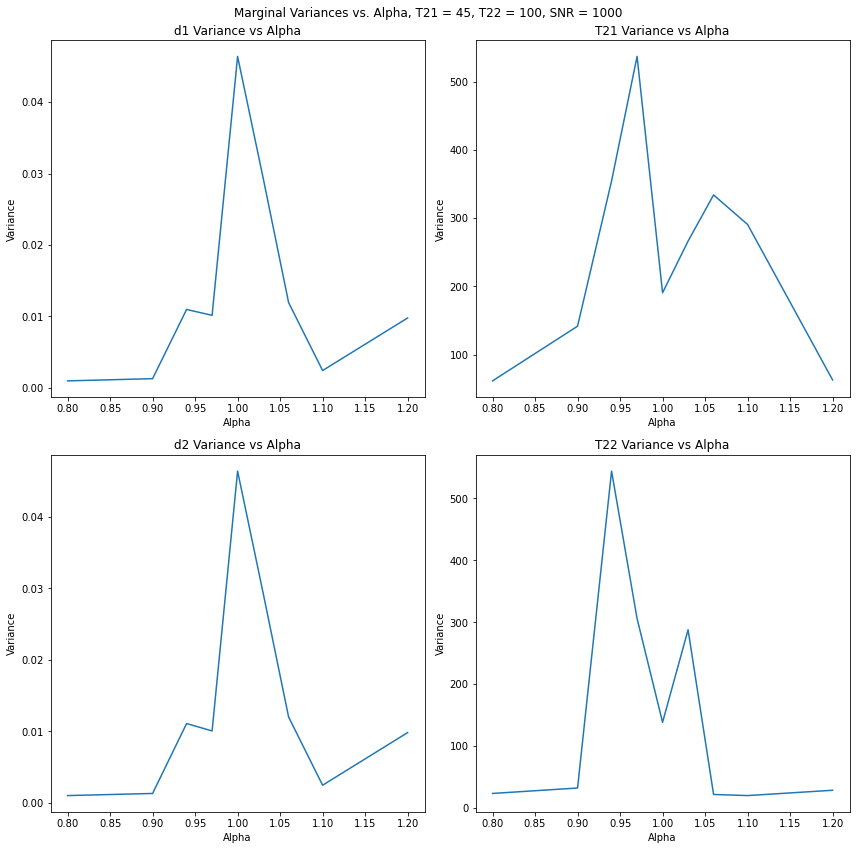

In [ ]:
alpha_set = [0.8, 0.9, 0.94, 0.97, 1.0, 1.03, 1.06, 1.1, 1.2]
fig, ax = plt.subplots(2,2,figsize = (12, 12), tight_layout=True)
fig.suptitle('Marginal Variances vs. Alpha, T21 = 45, T22 = 100, SNR = 1000')
ax[0,0].plot(alpha_set, marginal_variances[:,0])
ax[0,0].set_title('d1 Variance vs Alpha')
ax[0,0].set_xlabel('Alpha')
ax[0,0].set_ylabel('Variance')

ax[1,0].plot(alpha_set, marginal_variances[:,1])
ax[1,0].set_title('d2 Variance vs Alpha')
ax[1,0].set_xlabel('Alpha')
ax[1,0].set_ylabel('Variance')

ax[0,1].plot(alpha_set, (t_norm**2)*marginal_variances[:,2])
ax[0,1].set_title('T21 Variance vs Alpha')
ax[0,1].set_xlabel('Alpha')
ax[0,1].set_ylabel('Variance')

ax[1,1].plot(alpha_set, (t_norm**2)*marginal_variances[:,3])
ax[1,1].set_title('T22 Variance vs Alpha')
ax[1,1].set_xlabel('Alpha')
ax[1,1].set_ylabel('Variance')

plt.show()

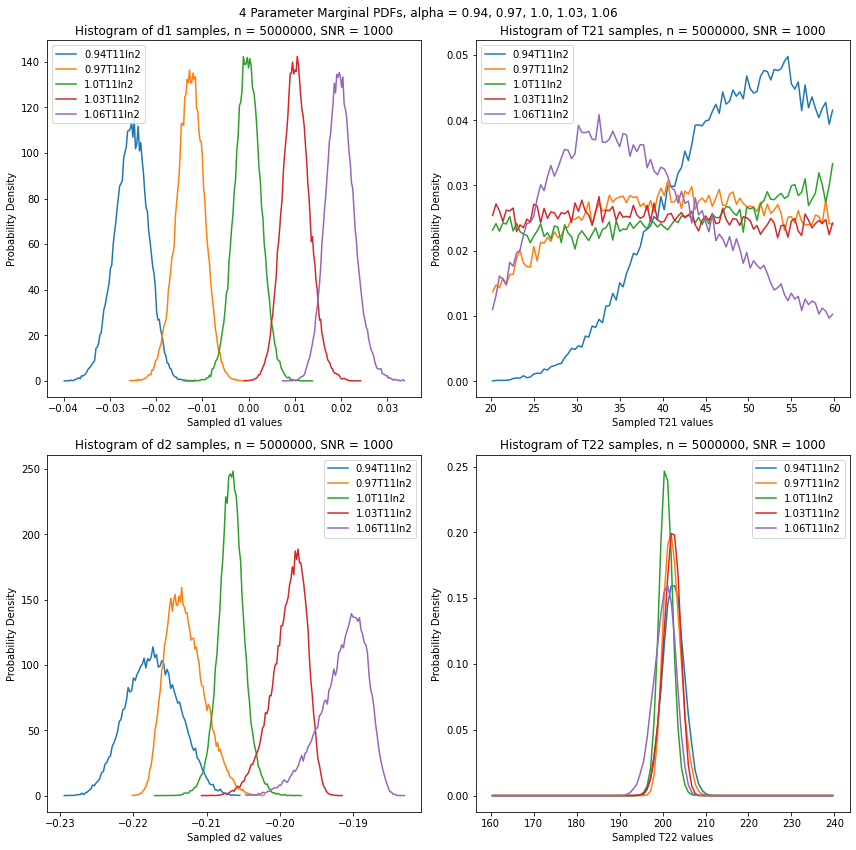

In [ ]:
fig, ax = plt.subplots(2,2,figsize = (12, 12), tight_layout=True)
fig.suptitle('4 Parameter Marginal PDFs, alpha = 0.94, 0.97, 1.0, 1.03, 1.06')
d1n1, d1bins1 = np.histogram(dset1[:,0], bins = 100, density = True)
ax[0,0].plot(0.5*(d1bins1[1:]+d1bins1[:-1]), d1n1, label='0.94T11ln2')

d1n2, d1bins2 = np.histogram(dset2[:,0], bins = 100, density = True)
ax[0,0].plot(0.5*(d1bins2[1:]+d1bins2[:-1]), d1n2, label='0.97T11ln2')

d1n3, d1bins3 = np.histogram(dset3[:,0], bins = 100, density = True)
ax[0,0].plot(0.5*(d1bins3[1:]+d1bins3[:-1]), d1n3, label='1.0T11ln2')

d1n4, d1bins4 = np.histogram(dset4[:,0], bins = 100, density = True)
ax[0,0].plot(0.5*(d1bins4[1:]+d1bins4[:-1]), d1n4, label='1.03T11ln2')

d1n5, d1bins5 = np.histogram(dset5[:,0], bins = 100, density = True)
ax[0,0].plot(0.5*(d1bins5[1:]+d1bins5[:-1]), d1n5, label='1.06T11ln2')
ax[0,0].set_xlabel('Sampled d1 values')
ax[0,0].set_ylabel('Probability Density')
ax[0,0].set_title('Histogram of d1 samples, n = %s, SNR = %s' % (n_iterations, SNR))
ax[0,0].legend()

d2n1, d2bins1 = np.histogram(dset1[:,1], bins = 100, density = True)
ax[1,0].plot(0.5*(d2bins1[1:]+d2bins1[:-1]), d2n1, label='0.94T11ln2')

d2n2, d2bins2 = np.histogram(dset2[:,1], bins = 100, density = True)
ax[1,0].plot(0.5*(d2bins2[1:]+d2bins2[:-1]), d2n2, label='0.97T11ln2')

d2n3, d2bins3 = np.histogram(dset3[:,1], bins = 100, density = True)
ax[1,0].plot(0.5*(d2bins3[1:]+d2bins3[:-1]), d2n3, label='1.0T11ln2')

d2n4, d2bins4 = np.histogram(dset4[:,1], bins = 100, density = True)
ax[1,0].plot(0.5*(d2bins4[1:]+d2bins4[:-1]), d2n4, label='1.03T11ln2')

d2n5, d2bins5 = np.histogram(dset5[:,1], bins = 100, density = True)
ax[1,0].plot(0.5*(d2bins5[1:]+d2bins5[:-1]), d2n5, label='1.06T11ln2')
ax[1,0].set_xlabel('Sampled d2 values')
ax[1,0].set_ylabel('Probability Density')
ax[1,0].set_title('Histogram of d2 samples, n = %s, SNR = %s' % (n_iterations, SNR))
ax[1,0].legend()

T21n1, T21bins1 = np.histogram(t_norm*dset1[:,2], bins = 100, density = True, range=[20,60])
ax[0,1].plot(0.5*(T21bins1[1:]+T21bins1[:-1]), T21n1, label='0.94T11ln2')

T21n2, T21bins2 = np.histogram(t_norm*dset2[:,2], bins = 100, density = True, range=[20,60])
ax[0,1].plot(0.5*(T21bins2[1:]+T21bins2[:-1]), T21n2, label='0.97T11ln2')

T21n3, T21bins3 = np.histogram(t_norm*dset3[:,2], bins = 100, density = True, range=[20,60])
ax[0,1].plot(0.5*(T21bins3[1:]+T21bins3[:-1]), T21n3, label='1.0T11ln2')

T21n4, T21bins4 = np.histogram(t_norm*dset4[:,2], bins = 100, density = True, range=[20,60])
ax[0,1].plot(0.5*(T21bins4[1:]+T21bins4[:-1]), T21n4, label='1.03T11ln2')

T21n5, T21bins5 = np.histogram(t_norm*dset5[:,2], bins = 100, density = True, range=[20,60])
ax[0,1].plot(0.5*(T21bins5[1:]+T21bins5[:-1]), T21n5, label='1.06T11ln2')

ax[0,1].set_xlabel('Sampled T21 values')
ax[0,1].set_ylabel('Probability Density')
ax[0,1].set_title('Histogram of T21 samples, n = %s, SNR = %s' % (n_iterations, SNR))
ax[0,1].legend()

T22n1, T22bins1 = np.histogram(t_norm*dset1[:,3], bins = 100, density = True, range=[160,240])
ax[1,1].plot(0.5*(T22bins1[1:]+T22bins1[:-1]), T22n1, label='0.94T11ln2')

T22n2, T22bins2 = np.histogram(t_norm*dset2[:,3], bins = 100, density = True, range=[160,240])
ax[1,1].plot(0.5*(T22bins2[1:]+T22bins2[:-1]), T22n2, label='0.97T11ln2')

T22n3, T22bins3 = np.histogram(t_norm*dset3[:,3], bins = 100, density = True, range=[160,240])
ax[1,1].plot(0.5*(T22bins3[1:]+T22bins3[:-1]), T22n3, label='1.0T11ln2')

T22n4, T22bins4 = np.histogram(t_norm*dset4[:,3], bins = 100, density = True, range=[160,240])
ax[1,1].plot(0.5*(T22bins4[1:]+T22bins4[:-1]), T22n4, label='1.03T11ln2')

T22n5, T22bins5 = np.histogram(t_norm*dset5[:,3], bins = 100, density = True, range=[160,240])
ax[1,1].plot(0.5*(T22bins5[1:]+T22bins5[:-1]), T22n5, label='1.06T11ln2')

ax[1,1].set_xlabel('Sampled T22 values')
ax[1,1].set_ylabel('Probability Density')
ax[1,1].set_title('Histogram of T22 samples, n = %s, SNR = %s' % (n_iterations, SNR))
ax[1,1].legend()

plt.show()

# Look at model selection methods as a function of TI

In [ ]:
#Given a set of TI values, calculates AIC, BIC, and F test to find the null points
TI_np_set = np.linspace(400, 430, 301)
AIC_BE_set = []
AIC_ME_set = []
FT_set = []
BIC_BE_set = []
BIC_ME_set = []
residual_ME_set = []
residual_BE_set = []
for TI_i in TI_np_set:
    #Iterate through TI values and generate NR for each
    #Calculate residuals and apply model selection methods
    d1 = c1*(1-2*np.exp(-TI_i/T11))
    d2 = c2*(1-2*np.exp(-TI_i/T12))
    data_TI = S_4_param(TE_set, d1, d2, T21, T22) + noise_TE(noise_sd)
    d0 = 0.1*np.random.uniform(-1,1)
    dT20 = 0.1*np.random.uniform(0,200)
    
    d1be, d2be, T21be, T22be = estimate_NLLS(S_4_param, TE_set, data_TI,p0 = [d1+d0,d2+d0,T21+dT20,T22+dT20])
    dme, T2me = estimate_NLLS(S_ME, TE_set, data_TI, p0=[(d1+d2)/2+d0,(T21+T22)/2+dT20])
    
    #joint_BE = pdf_np_4_param(data_TI, noise_sd)
    #max_BE = joint_BE(TE_set,d1be,d2be,T21be,T22be)
    #joint_ME = pdf_np_ME(data_TI, noise_sd)
    #max_ME = joint_ME(TE_set,dme,T2me)
    
    residual_BE = np.sum((data_TI-S_4_param(TE_set,d1be,d2be,T21be,T22be))**2)
    residual_BE_set.append(residual_BE)
    residual_ME = np.sum((data_TI-S_ME(TE_set,dme,T2me))**2)
    residual_ME_set.append(residual_ME)
    
    F_numerator = (residual_ME-residual_BE)/(4-2)
    F_denominator = residual_BE/(n_TE-4)
    F_test = F_numerator/F_denominator
    FT_set.append(F_test)
    
    AIC_BE = residual_BE/(n_TE*noise_sd**2)+n_TE*np.log(2*math.pi*noise_sd**2)+2*4#n_TE*np.log(residual_BE)+2*4
    AIC_BE_set.append(AIC_BE)
    AIC_ME = residual_ME/(n_TE*noise_sd**2)+n_TE*np.log(2*math.pi*noise_sd**2)+2*2#n_TE*np.log(residual_ME)+2*2
    AIC_ME_set.append(AIC_ME)
    
    BIC_BE = residual_BE/(1**2)+n_TE*np.log(2*math.pi*1**2)+4*np.log(n_TE)#n_TE*np.log(residual_BE/n_TE)+4*np.log(n_TE)
    BIC_BE_set.append(BIC_BE)
    BIC_ME = residual_ME/(1**2)+n_TE*np.log(2*math.pi*1**2)+2*np.log(n_TE)#n_TE*np.log(residual_ME/n_TE)+2*np.log(n_TE)
    BIC_ME_set.append(BIC_ME)

<ipython-input-405-c5005d84fa97>:17: RuntimeWarning: overflow encountered in exp
  model = d1*np.exp(-TE/T21)+d2*np.exp(-TE/T22)


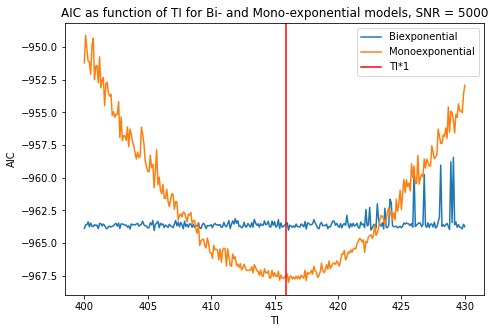

In [ ]:
fig, ax = plt.subplots(figsize=(7.5,5))
ax.plot(TI_np_set, AIC_BE_set, label='Biexponential')
ax.plot(TI_np_set, AIC_ME_set, label='Monoexponential')
#ax.plot(TI_np_set, BIC_BE_set, label='Biexponential')
#ax.plot(TI_np_set, BIC_ME_set, label='Monoexponential')
#ax.plot(TI_np_set, residual_ME_set, label='Monoexponential residual')
#ax.plot(TI_np_set, smooth(AIC_ME_set, 20))
#ax.plot(TI_np_set, FT_set, label='F Test')
ax.axvline(x=415.9, label='TI*1', color='r')
#ax.axvline(x=831, label='TI*2', color='g')
ax.legend()
ax.set_xlabel('TI')
ax.set_ylabel('AIC')
#ax.set_ylim(-925,-800)
ax.set_title('AIC as function of TI for Bi- and Mono-exponential models, SNR = %s'%SNR)
plt.show()